# Global Terrorism

The Global Terrorism Database (GTD) is an open-source database including information on terrorist attacks around the world from 1970 through 2016.   
You can access and download the raw data here:  https://www.kaggle.com/START-UMD/gtd/data

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
import warnings 
warnings.simplefilter('ignore')
np.random.seed(101)
# Set plotting styles
sns.set_style('white')  

In [2]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# For figures to show up in the notebook:
init_notebook_mode(connected=True) 

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist

In [5]:
import keras
from keras.layers import Dense, Conv1D, Flatten, Dropout, GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


----
# Get the data

In [6]:
# Read in raw data and set as a data frame: df
raw_df = pd.read_csv('global_terrorism_db_0617dist.csv', encoding="ISO-8859-1")

In [7]:
# Drop duplicate data
raw_df = raw_df.drop_duplicates()

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168109 entries, 0 to 170350
Columns: 135 entries, eventid to related
dtypes: float64(77), object(58)
memory usage: 174.4+ MB


In [9]:
raw_df.head(2)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,1.970000e+11,1970.0,7.0,2.0,NaN,0.0,NaN,58.0,Dominican Republic,2.0,...,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN
1,1.970000e+11,1970.0,0.0,0.0,NaN,0.0,NaN,130.0,Mexico,1.0,...,NaN,NaN,NaN,NaN,PGIS,0.0,1.0,1.0,1.0,NaN


----
# Data Cleaning

In [10]:
# List column names
list(raw_df.columns)

['eventid',
 'iyear',
 'imonth',
 'iday',
 'approxdate',
 'extended',
 'resolution',
 'country',
 'country_txt',
 'region',
 'region_txt',
 'provstate',
 'city',
 'latitude',
 'longitude',
 'specificity',
 'vicinity',
 'location',
 'summary',
 'crit1',
 'crit2',
 'crit3',
 'doubtterr',
 'alternative',
 'alternative_txt',
 'multiple',
 'success',
 'suicide',
 'attacktype1',
 'attacktype1_txt',
 'attacktype2',
 'attacktype2_txt',
 'attacktype3',
 'attacktype3_txt',
 'targtype1',
 'targtype1_txt',
 'targsubtype1',
 'targsubtype1_txt',
 'corp1',
 'target1',
 'natlty1',
 'natlty1_txt',
 'targtype2',
 'targtype2_txt',
 'targsubtype2',
 'targsubtype2_txt',
 'corp2',
 'target2',
 'natlty2',
 'natlty2_txt',
 'targtype3',
 'targtype3_txt',
 'targsubtype3',
 'targsubtype3_txt',
 'corp3',
 'target3',
 'natlty3',
 'natlty3_txt',
 'gname',
 'gsubname',
 'gname2',
 'gsubname2',
 'gname3',
 'gsubname3',
 'motive',
 'guncertain1',
 'guncertain2',
 'guncertain3',
 'individual',
 'nperps',
 'nperpcap',
 

In [11]:
# Subset the raw_df with all the columns I want.
df = raw_df[['iyear', 'country_txt', 'region_txt', 'provstate', 'city',
             'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt',
             'nkill', 'summary', 'success']]

In [12]:
# Rename some columns
df.rename(columns={'iyear':'year', 'country_txt':'country', 'region_txt':'region', 'provstate':'state',
                   'attacktype1_txt':'attack_type', 'targtype1_txt':'target_type', 'weaptype1_txt':'weapon_type', 
                   'nkill':'killed'}, 
          inplace=True) 

In [13]:
# Check each column's missing value count:
df.isnull().sum()

year               0
country            1
region             1
state          14229
city             447
attack_type        1
target_type        1
weapon_type        1
killed          9379
summary        64600
success            1
dtype: int64

In [14]:
# The 'country' column has one missing value, check it:
df[df.country.isnull()]

,year,country,region,state,city,attack_type,target_type,weapon_type,killed,summary,success
114239,2.010000e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Drop that missing value row from the 'country' column
df = df.dropna(subset=['country'], axis=0)

In [16]:
# Convert data types for some columns from float to int
df[['year', 'success']] = df[['year', 'success']].astype(int)

In [17]:
# Check 'success' column's value_counts
df['success'].value_counts()

1    150806
0     17302
Name: success, dtype: int64

Text(0,0.5,'Count')

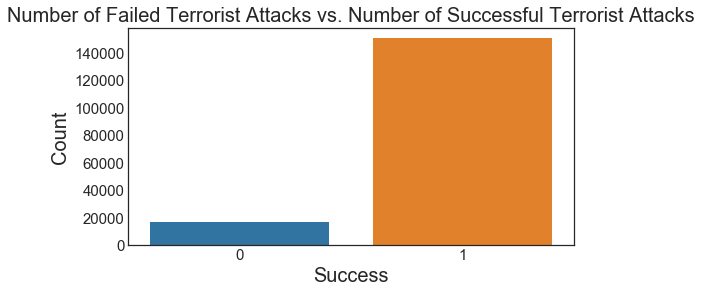

In [18]:
sns.set_style('white')  
plt.figure(figsize=(8, 4))
sns.countplot(x="success", data=df)
plt.title('Number of Failed Terrorist Attacks vs. Number of Successful Terrorist Attacks', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Success', fontsize=20) 
plt.ylabel('Count', fontsize=20)

The target's classes are not balanced, so we need to balance between the classes when we fit with training data.

----
### Another crucial step during the data cleaning process is to check for outliers. 

In [19]:
# The 'killed' column is the only column with numerical values. 
# Thus, the only column that can potentially have outliers.
df['killed'].describe()

count    158730.000000
mean          2.411819
std          11.392818
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        1500.000000
Name: killed, dtype: float64

Text(0,0.5,'Frequency Count')

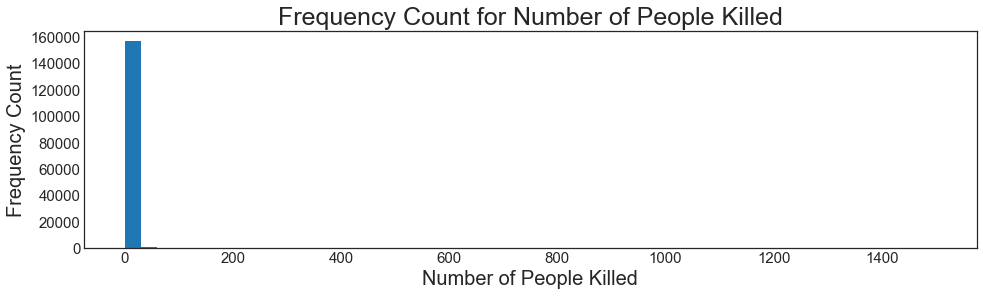

In [20]:
# Visualize the 'killed' column:
sns.set_style('white')  
plt.figure(figsize=(16, 4))
df['killed'].plot.hist(bins=50)
plt.title('Frequency Count for Number of People Killed', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of People Killed', fontsize=20) 
plt.ylabel('Frequency Count', fontsize=20)

In [21]:
# Check terrorist attacks where over 100 people killed
over100_killed = df[df.killed > 100]
# There are 178 terrorist attacks where over 100 people killed.

Text(0,0.5,'Frequency Count')

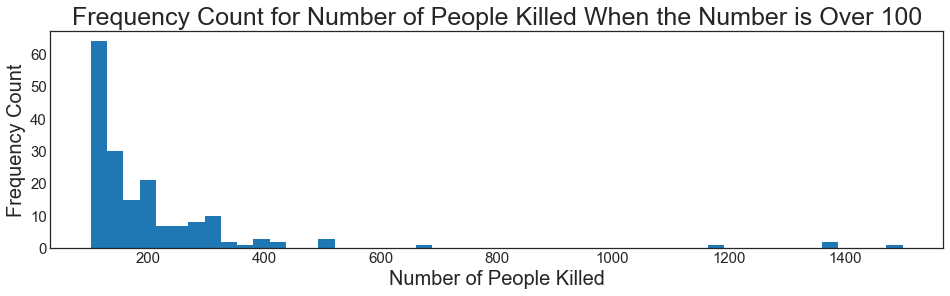

In [22]:
sns.set_style('white')  
plt.figure(figsize=(16, 4))
over100_killed['killed'].plot.hist(bins=50)
plt.title('Frequency Count for Number of People Killed When the Number is Over 100', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of People Killed', fontsize=20) 
plt.ylabel('Frequency Count', fontsize=20)

In [23]:
over600_killed = df[df.killed > 600]

Text(0,0.5,'Frequency Count')

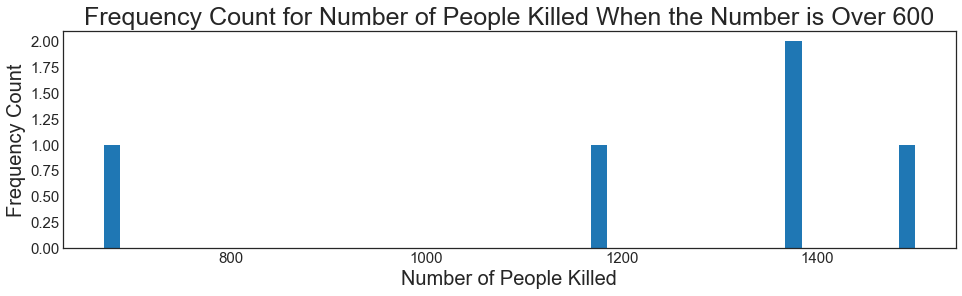

In [24]:
sns.set_style('white')  
plt.figure(figsize=(16, 4))
over600_killed['killed'].plot.hist(bins=50)
plt.title('Frequency Count for Number of People Killed When the Number is Over 600', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of People Killed', fontsize=20) 
plt.ylabel('Frequency Count', fontsize=20)

In [25]:
over600_killed

,year,country,region,state,city,attack_type,target_type,weapon_type,killed,summary,success
55860,1994,Rwanda,Sub-Saharan Africa,Kigali,Gikoro,Armed Assault,Private Citizens & Property,Firearms,1180.0,NaN,1
73054,2001,United States,North America,New York,New York City,Hijacking,Private Citizens & Property,Vehicle (not to include vehicle-borne explosiv...,1383.0,09/11/2001: This was one of four related attac...,1
73055,2001,United States,North America,New York,New York City,Hijacking,Private Citizens & Property,Vehicle (not to include vehicle-borne explosiv...,1382.0,09/11/2001: This was one of four related attac...,1
133024,2014,Iraq,Middle East & North Africa,Nineveh,Badush,Armed Assault,Police,Explosives/Bombs/Dynamite,670.0,06/10/2014: Assailants stormed Badush prison i...,1
133317,2014,Iraq,Middle East & North Africa,Saladin,Tikrit,Hostage Taking (Kidnapping),Military,Firearms,1500.0,06/12/2014: Assailants abducted approximately ...,1


These are legitimate terrorist attack incidents.    
Also, we we make predictions on whether a terorist attack is a success or a failure, we do not include the column that indicates how many people killed.

----
# Exploratory Data Analysis

Is there a trend in number of terrorist attacks over the years?    
Increased dramatically in recent decade.

Text(0,0.5,'Count')

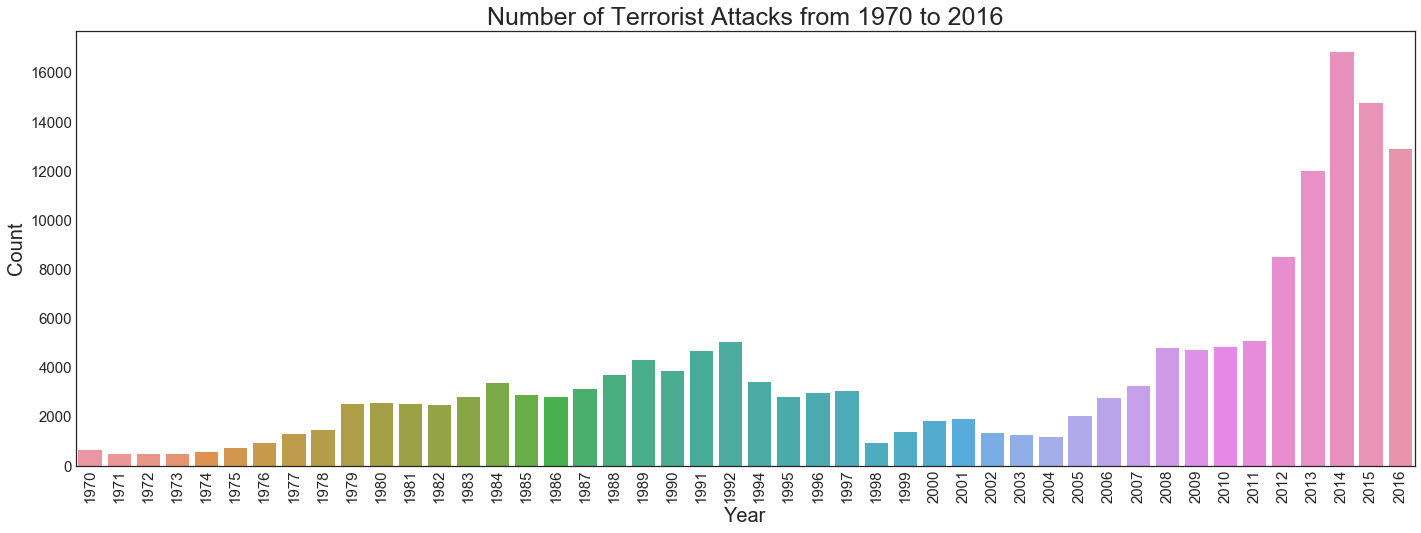

In [26]:
# Number of Terrorist Attacks from 1970 to 2016
sns.set_style('white')  
plt.figure(figsize=(24, 8))
sns.countplot('year', data=df)
plt.title('Number of Terrorist Attacks from 1970 to 2016', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Year', fontsize=20) 
plt.ylabel('Count', fontsize=20)

----
Which regions have the highest number of terrorist attacks?

Text(0,0.5,'Count')

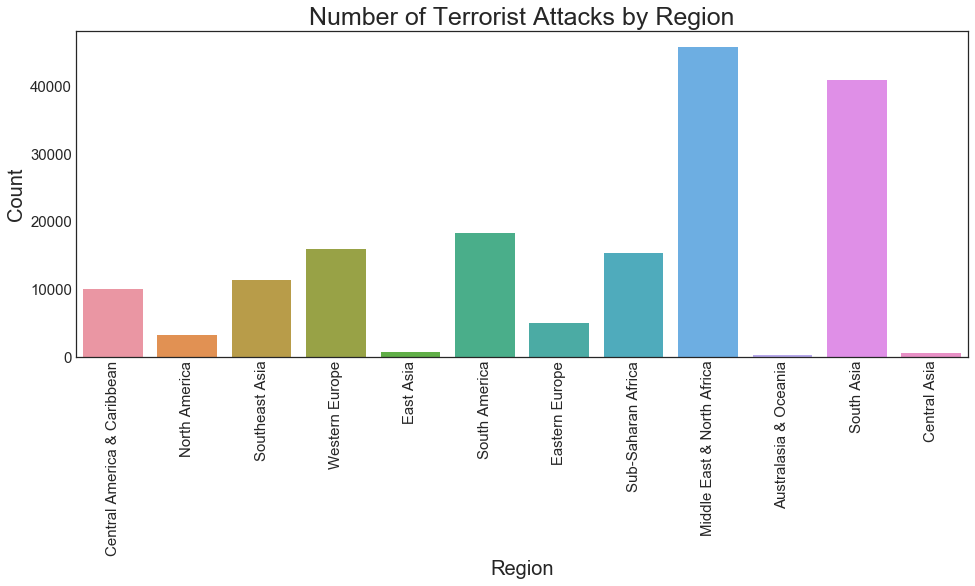

In [27]:
# Number of Terrorist Attacks by Region
sns.set_style('white')  
plt.figure(figsize=(16, 6))
sns.countplot('region', data=df)
plt.title('Number of Terrorist Attacks by Region', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Region', fontsize=20) 
plt.ylabel('Count', fontsize=20)

In [28]:
# Top 10 countries with the most terrorist attack incidents from 1970 to 2016
# df_sorted = df.sort_values(by='killed', ascending=False)
# df_sorted[['year', 'country', 'killed']].head(5)

df_country = df.groupby('country')[['year']].count()
df_country.columns = ['count']
df_country = df_country.sort_values(by='count',ascending=False)
df_country = df_country.reset_index()

In [29]:
top10_country = df_country[:10]
top10_country

,country,count
0,Iraq,21617
1,Pakistan,13272
2,Afghanistan,11256
3,India,10930
4,Colombia,8015
5,Philippines,6196
6,Peru,6012
7,El Salvador,5149
8,United Kingdom,5066
9,Turkey,4060


Text(0,0.5,'Count')

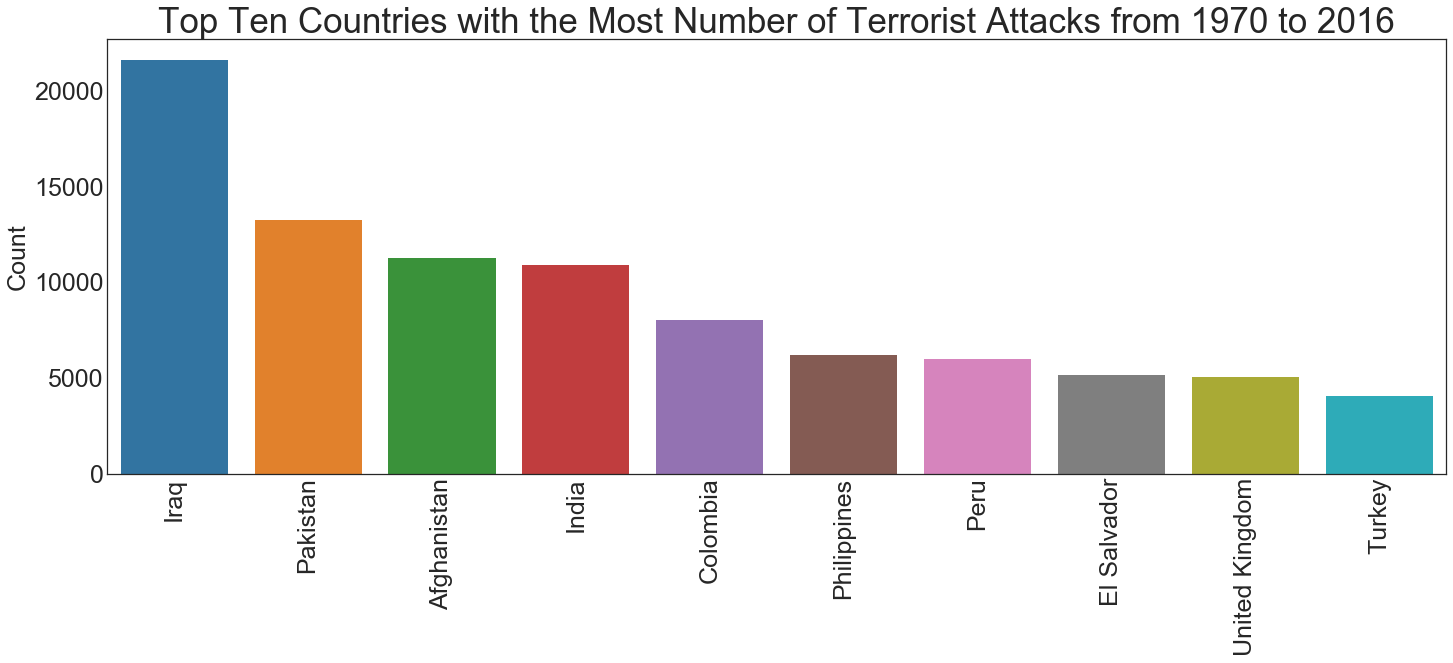

In [30]:
# Top Ten Countries with the Most Number of Terrorist Attacks from 1970 to 2016
sns.set_style('white')  
plt.figure(figsize=(24, 8))
sns.barplot(x="country", y="count", data=top10_country)
plt.title('Top Ten Countries with the Most Number of Terrorist Attacks from 1970 to 2016', fontsize=35)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('', fontsize=20) 
plt.ylabel('Count', fontsize=25)

----
How about number of people killed? Is there a trend?    
Number of people killed are not increasing dramatically, but there are a few large killings since the 1990's.

Text(0,0.5,'Count')

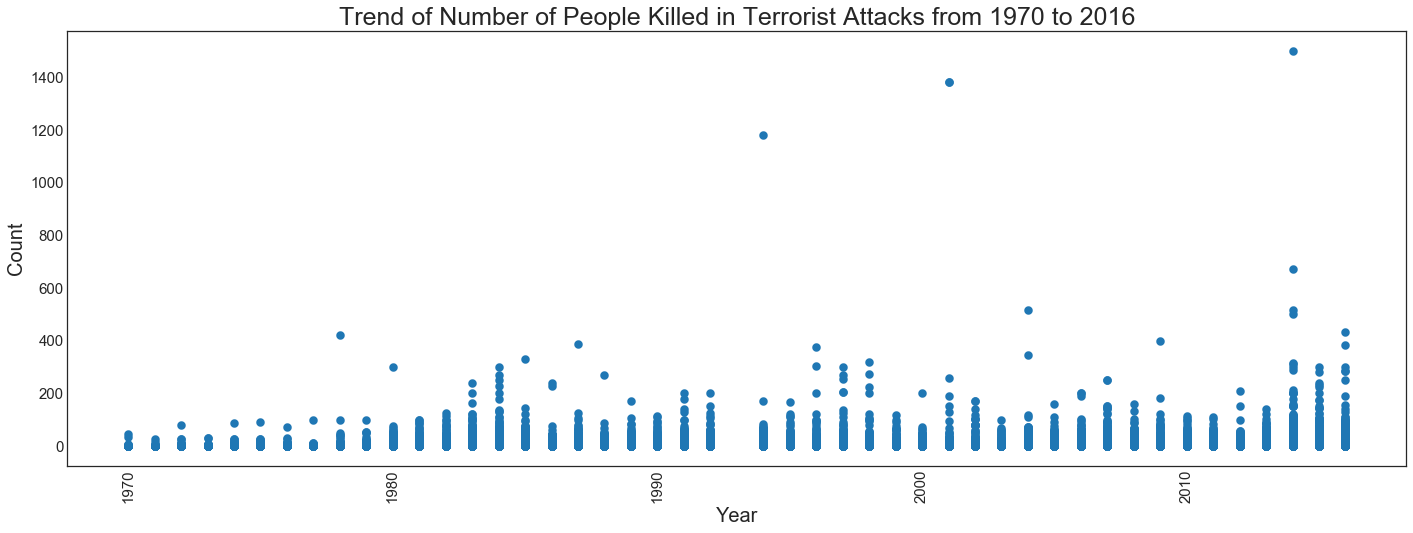

In [31]:
# Trend of Number of People Killed in Terrorist Attacks from 1970 to 2016   
sns.set_style('white')  
df.plot.scatter(x='year', y='killed', figsize=(24, 8), lw=4)
plt.title('Trend of Number of People Killed in Terrorist Attacks from 1970 to 2016', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Year', fontsize=20) 
plt.ylabel('Count', fontsize=20)

In [32]:
# Top 5 terrorost attackes with most number of people killed
df_sorted = df.sort_values(by='killed', ascending=False)
df_sorted[['year', 'country', 'killed']].head(5)

,year,country,killed
133317,2014,Iraq,1500.0
73054,2001,United States,1383.0
73055,2001,United States,1382.0
55860,1994,Rwanda,1180.0
133024,2014,Iraq,670.0


Number of attacks by attack type:

In [33]:
df.attack_type.value_counts()

Bombing/Explosion                      81900
Armed Assault                          39781
Assassination                          18212
Hostage Taking (Kidnapping)            10176
Facility/Infrastructure Attack          9334
Unknown                                 6316
Unarmed Assault                          902
Hostage Taking (Barricade Incident)      889
Hijacking                                598
Name: attack_type, dtype: int64

In [34]:
df_attackType = df.loc[df.attack_type != 'Unknown', ['year', 'attack_type']]
df_attackType.head()

,year,attack_type
0,1970,Assassination
1,1970,Hostage Taking (Kidnapping)
2,1970,Assassination
3,1970,Bombing/Explosion
4,1970,Facility/Infrastructure Attack


In [35]:
df_country = df.groupby('country')[['year']].count()
df_country.columns = ['count']
df_country = df_country.sort_values(by='count',ascending=False)
df_country = df_country.reset_index()

Text(0,0.5,'Count')

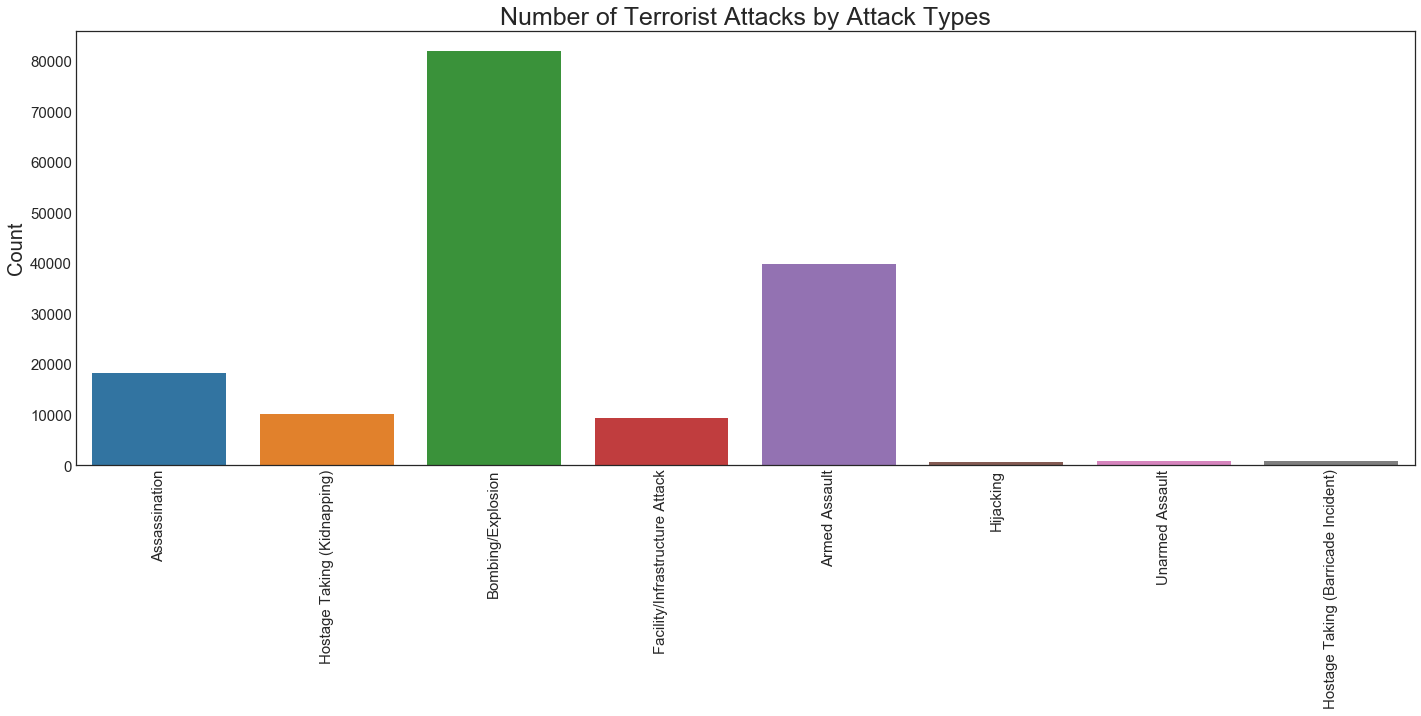

In [36]:
# Number of Terrorist Attacks by Attack Types
sns.set_style('white')  
plt.figure(figsize=(24, 8))
sns.countplot('attack_type', data=df_attackType)
plt.title('Number of Terrorist Attacks by Attack Types', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('') 
plt.ylabel('Count', fontsize=20)

----
Which target group is most vulnerable during terrorist attacks?

Text(0,0.5,'Count')

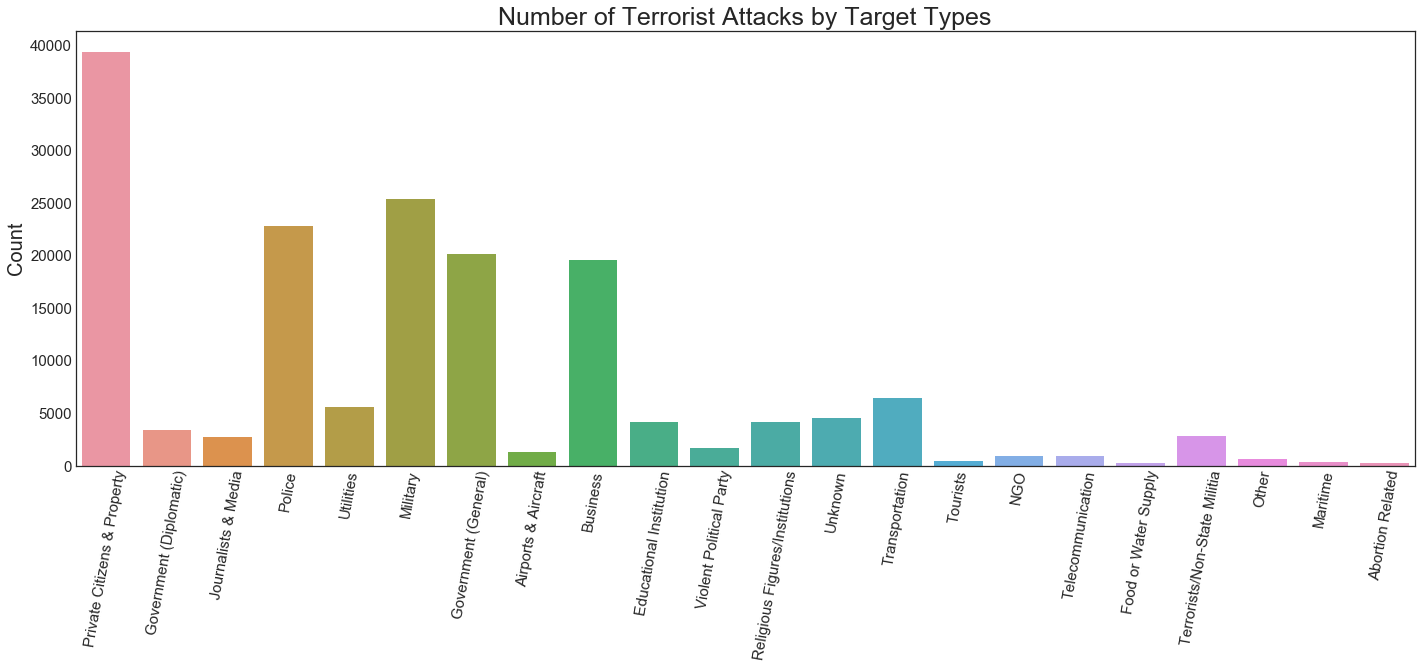

In [37]:
# Number of Terrorist Attacks by Target Types
sns.set_style('white')  
plt.figure(figsize=(24, 8))
sns.countplot('target_type', data=df)
plt.title('Number of Terrorist Attacks by Target Types', fontsize=25)
plt.xticks(rotation=80, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('') 
plt.ylabel('Count', fontsize=20)

Weapon use:

In [38]:
df['weapon_type'] = df['weapon_type'].apply(lambda s: s.replace('Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Vehicle'))

Text(0,0.5,'Count')

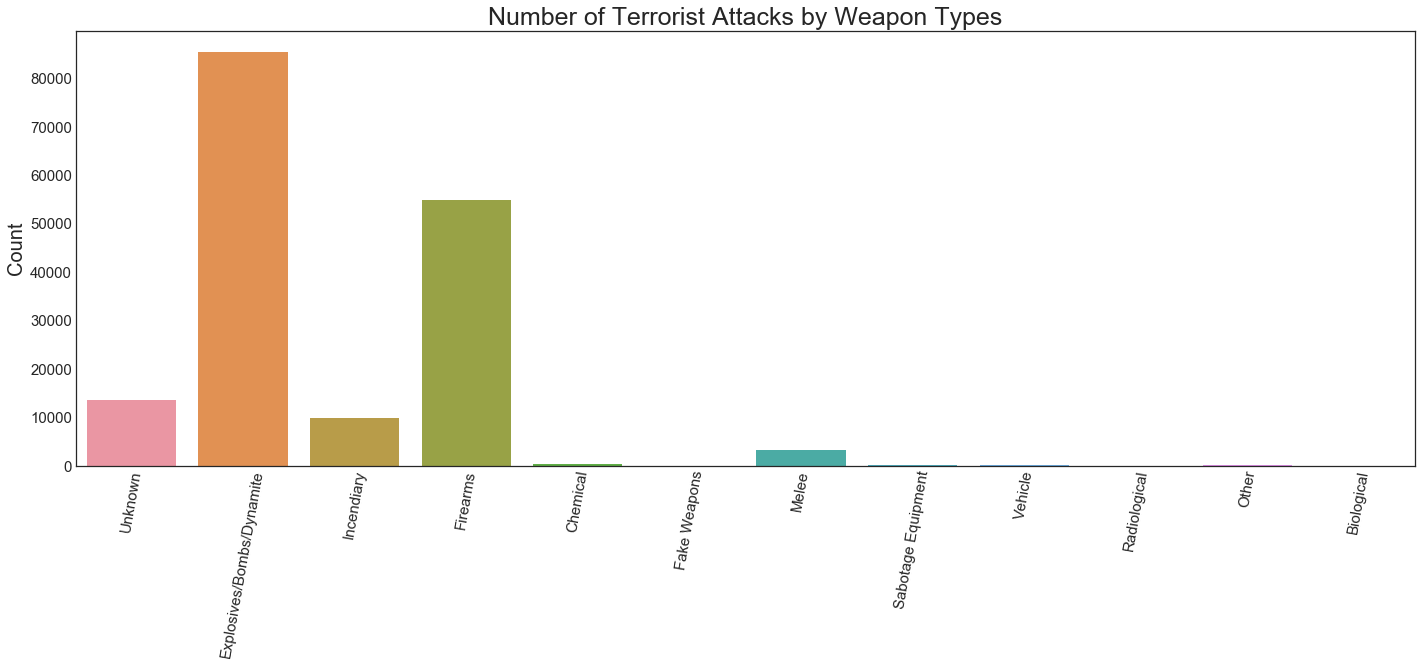

In [39]:
# Number of Terrorist Attacks by Weapon Type
sns.set_style('white')  
plt.figure(figsize=(24, 8))
sns.countplot('weapon_type', data=df)
plt.title('Number of Terrorist Attacks by Weapon Types', fontsize=25)
plt.xticks(rotation=80, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('') 
plt.ylabel('Count', fontsize=20)

Now, let's combine features together to get even more insights. For instance, if I combine 'year' and 'region', I get the following graph.

Time trend for regions:

In [40]:
# Make a frequency table of year and region
df_region = pd.crosstab(index=df.year, columns=df.region)  
# df_region

Text(0,0.5,'Count')

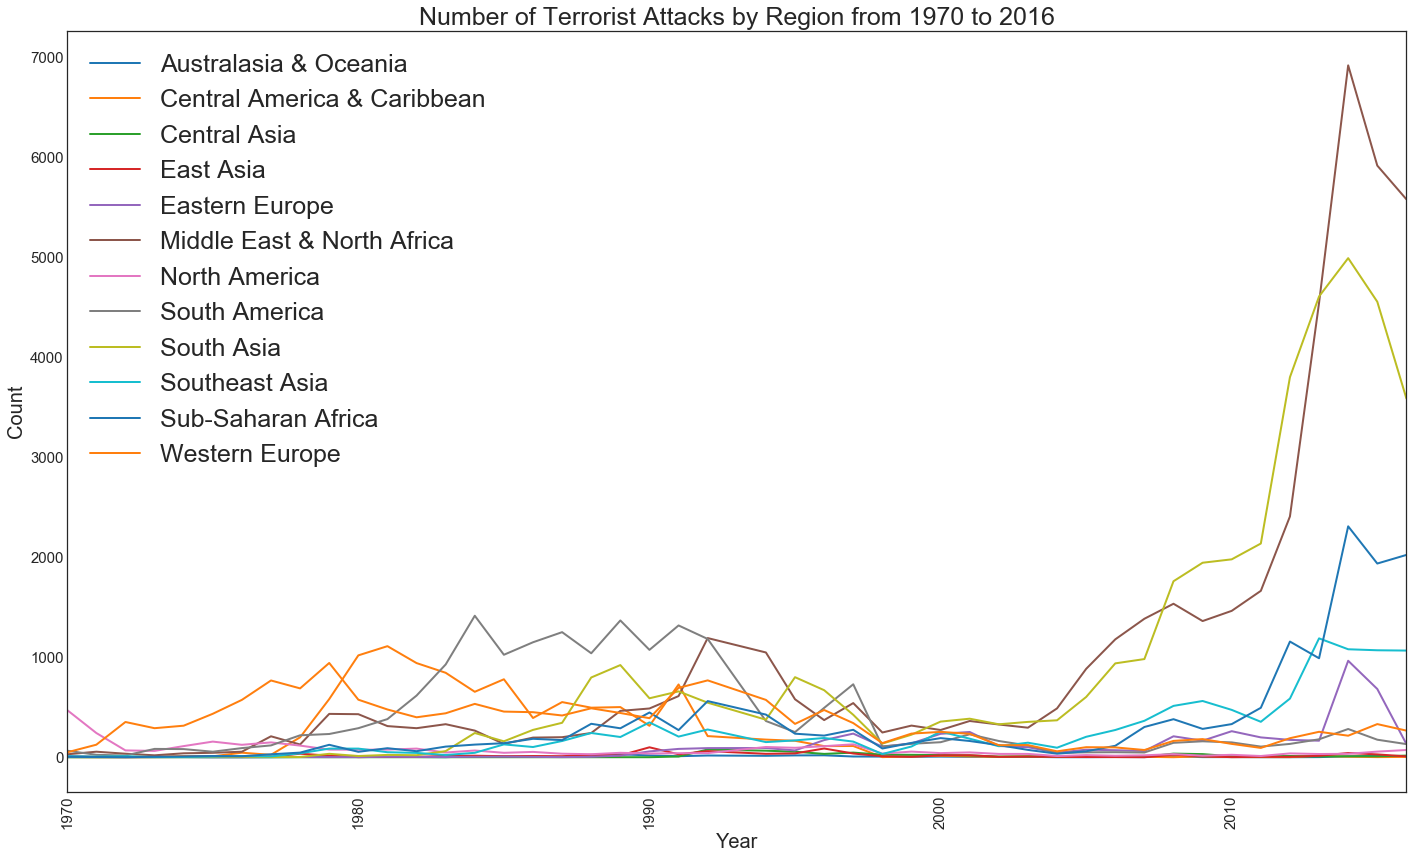

In [41]:
# Number of Terrorist Attacks by Region from 1970 to 2016
sns.set_style('white')  
df_region.plot(figsize=(24, 14), lw=2)
plt.legend(fontsize=25)
plt.title('Number of Terrorist Attacks by Region from 1970 to 2016', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Count', fontsize=20)

----
Combine attack types and regions:

In [42]:
# Make a frequency table of region and attack types
df_region_attack = pd.crosstab(index=df.region, columns=df.attack_type)  
df_region_attack

attack_type,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault,Unknown
region,,,,,,,,,
Australasia & Oceania,49,30,73,67,3,5,11,10,16
Central America & Caribbean,4293,1245,3116,373,26,176,498,19,338
Central Asia,115,114,228,19,8,2,45,4,16
East Asia,110,55,323,186,18,3,14,42,23
Eastern Europe,1241,385,2711,238,26,20,216,57,113
Middle East & North Africa,8715,4057,27772,987,126,87,2412,164,1542
North America,402,236,1513,867,18,63,113,69,32
South America,3746,2698,8770,737,66,227,1364,45,741
South Asia,10391,3828,19786,1871,85,100,2984,270,1673


Text(0.5,69,'')

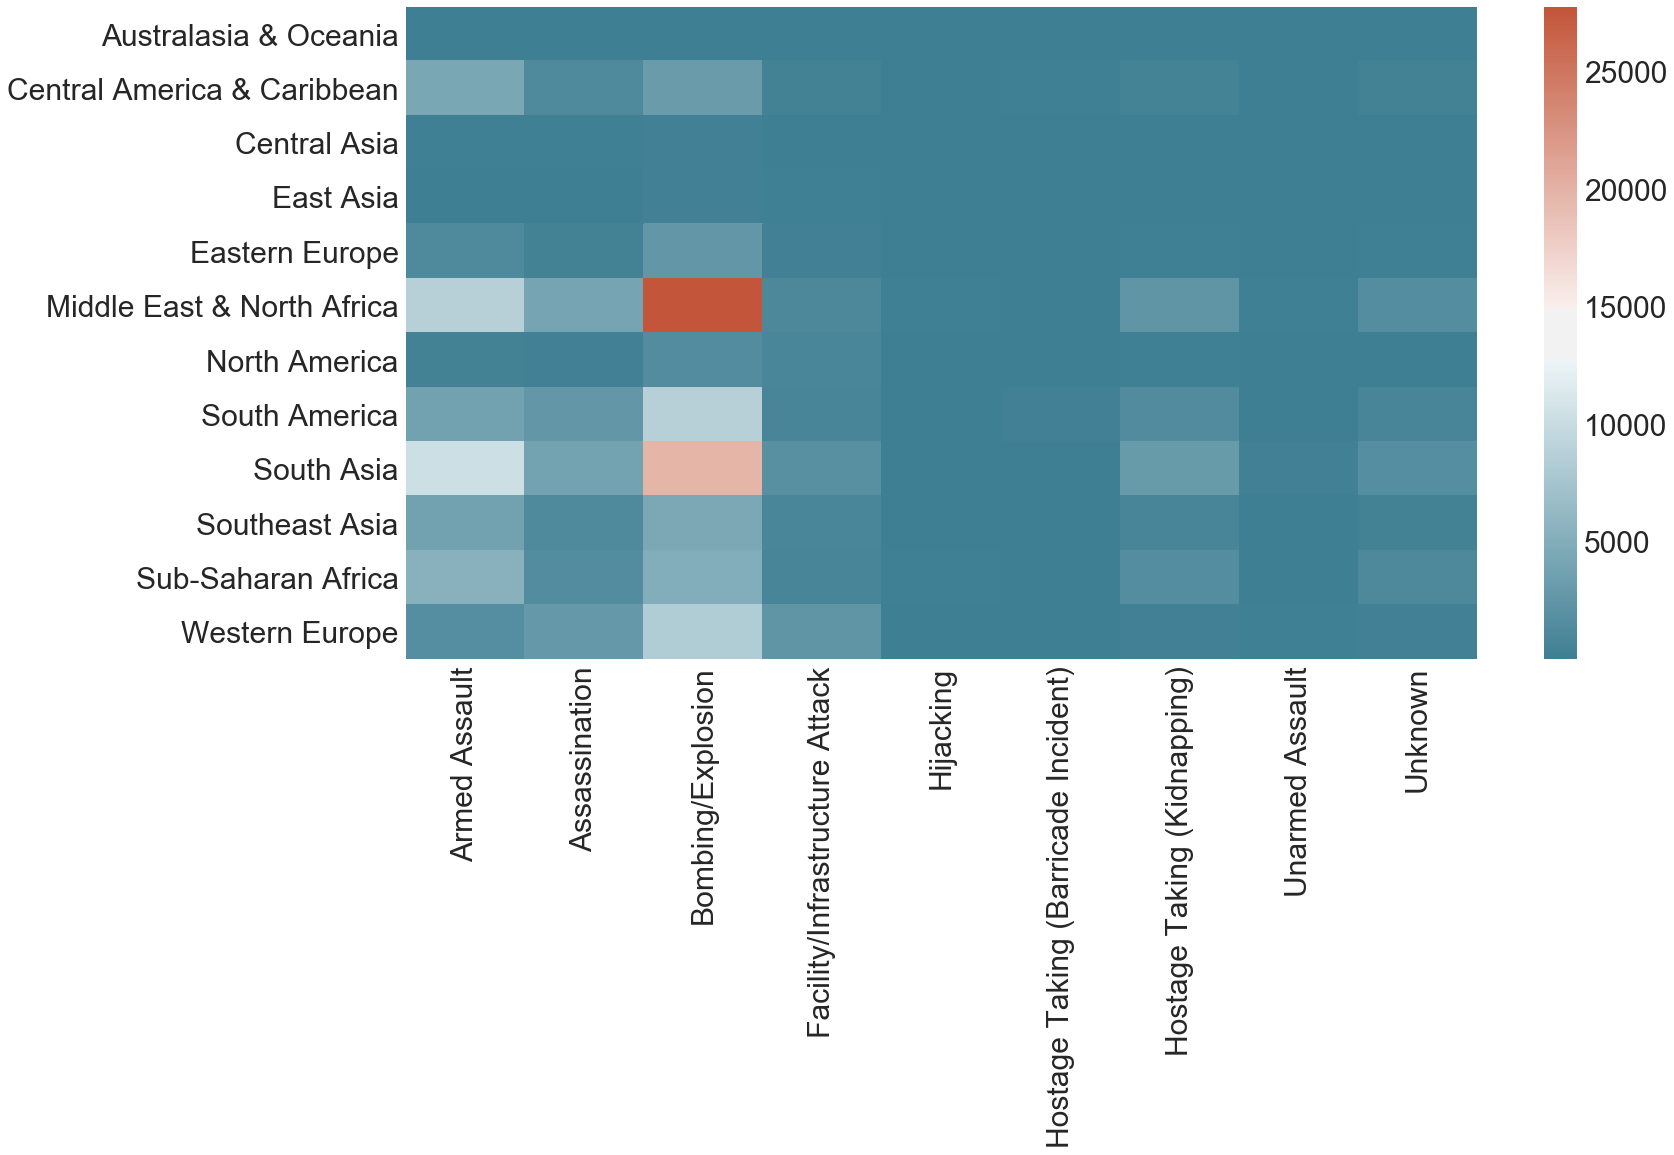

In [43]:
# Heatmap for Region vs. Attack Type  
sns.set_style('white')  
plt.figure(figsize=(24, 12))
sns.set(font_scale=3)
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df_region_attack, cmap=cmap )
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('')
plt.xlabel('')

Bombing/explosion are prevalent in the Middle East & North Africa and South Asia regions.

----

----
Combining attack types and number of people killed gives us the insigight of
which attack type is most lethal (kill most people).

In [44]:
# Get data into the right shape
df_attacktype = df.groupby('attack_type')[['killed']].sum()
df_attacktype.reset_index(inplace=True)
df_attacktype

,attack_type,killed
0,Armed Assault,152920.0
1,Assassination,23795.0
2,Bombing/Explosion,145272.0
3,Facility/Infrastructure Attack,3446.0
4,Hijacking,3685.0
5,Hostage Taking (Barricade Incident),3534.0
6,Hostage Taking (Kidnapping),21131.0
7,Unarmed Assault,788.0
8,Unknown,28257.0


----
Overlay the two graphs:

Text(0,0.5,'Count')

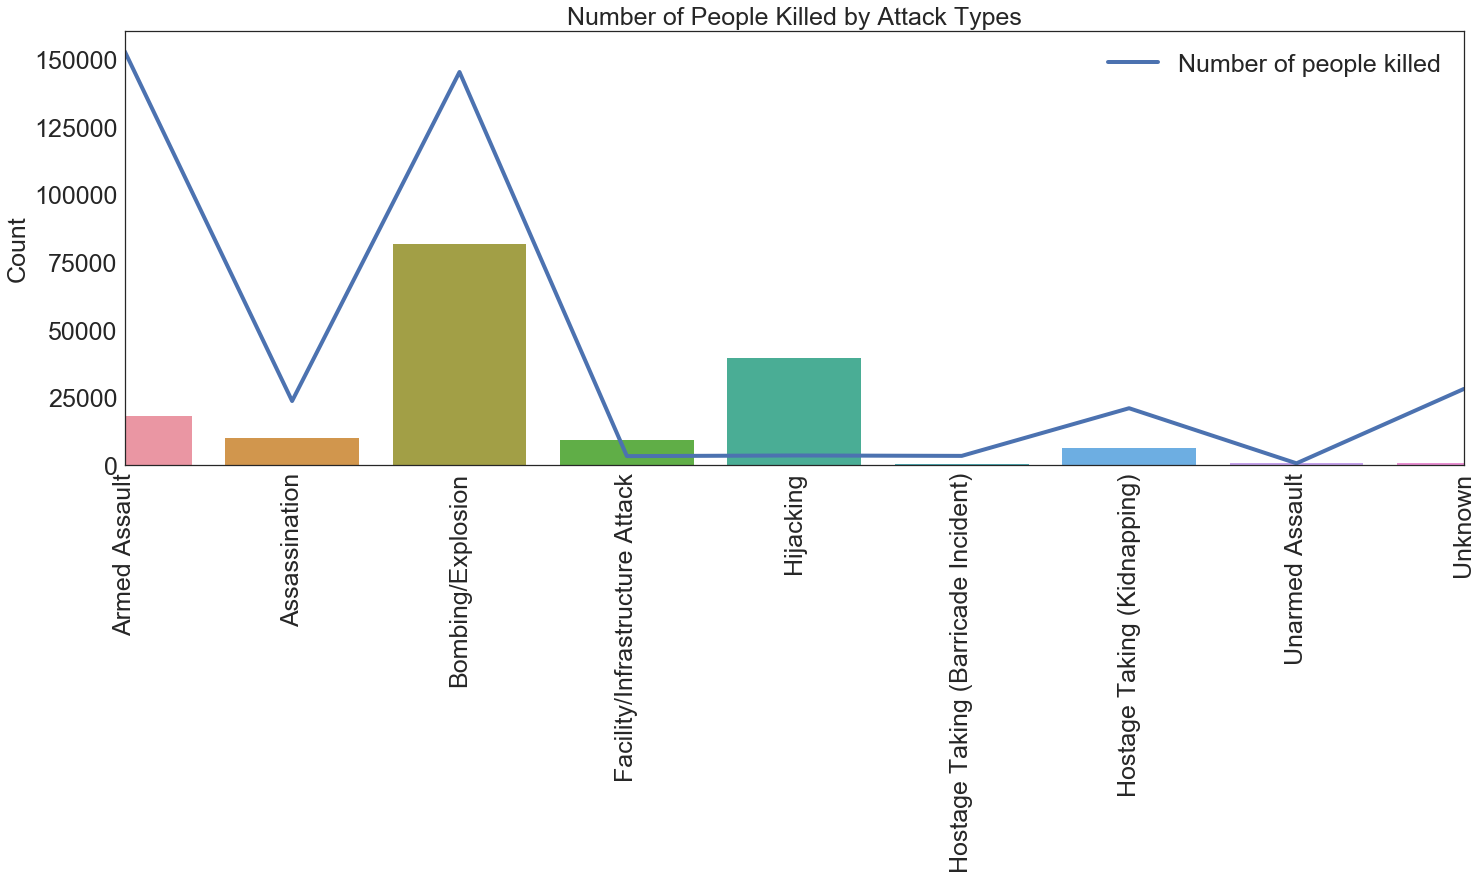

In [45]:
# Number of Terrorist Attacks and Number of People Killed and Wounded by Attack Types
sns.set_style('white')  
fig, ax = plt.subplots() 
sns.countplot('attack_type', data=df, ax=ax)
df_attacktype.plot(x='attack_type', y='killed', figsize=(24, 8), lw=4, ax=ax)
plt.legend(['Number of people killed'], fontsize=25)
plt.title('Number of People Killed by Attack Types', fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('')
plt.ylabel('Count', fontsize=25)

In [46]:
df.isnull().sum()

year               0
country            0
region             0
state          14228
city             446
attack_type        0
target_type        0
weapon_type        0
killed          9378
summary        64599
success            0
dtype: int64

----
### ANOVA Test

ANOVA Test - compare means of number of people killed for each attack type on a per-incident basis

In [47]:
df.head(2)

,year,country,region,state,city,attack_type,target_type,weapon_type,killed,summary,success
0,1970,Dominican Republic,Central America & Caribbean,NaN,Santo Domingo,Assassination,Private Citizens & Property,Unknown,1.0,NaN,1
1,1970,Mexico,North America,NaN,Mexico city,Hostage Taking (Kidnapping),Government (Diplomatic),Unknown,0.0,NaN,1


In [48]:
# Get data into the right shape
df_anova= df.pivot_table(index='year', columns='attack_type', values='killed', aggfunc=np.sum)
del df_anova['Unknown']
df_anova.head()

attack_type,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault
year,,,,,,,,
1970,36.0,15.0,96.0,9.0,1.0,0.0,10.0,0.0
1971,14.0,73.0,79.0,1.0,0.0,0.0,2.0,NaN
1972,58.0,208.0,281.0,1.0,5.0,0.0,12.0,NaN
1973,41.0,171.0,75.0,0.0,34.0,38.0,11.0,0.0
1974,34.0,161.0,289.0,0.0,1.0,35.0,14.0,1.0


In [49]:
# df_anova.info()

In [50]:
list(df_anova.columns)

['Armed Assault',
 'Assassination',
 'Bombing/Explosion',
 'Facility/Infrastructure Attack',
 'Hijacking',
 'Hostage Taking (Barricade Incident)',
 'Hostage Taking (Kidnapping)',
 'Unarmed Assault']

In [51]:
# Delete NaN values from each individual column. 
# (get the columns ready to be the arguments for the ANOVA test function)
Armed_Assault = df_anova['Armed Assault'].dropna()
Assassination = df_anova['Assassination'].dropna()
Bombing_Explosion = df_anova['Bombing/Explosion'].dropna()
Facility_Infrastructure_Attack = df_anova['Facility/Infrastructure Attack'].dropna()
Hijacking = df_anova['Hijacking'].dropna()
Hostage_Taking_Barricade_Incident = df_anova['Hostage Taking (Barricade Incident)'].dropna()
Hostage_Taking_Kidnapping = df_anova['Hostage Taking (Kidnapping)'].dropna()
Unarmed_Assault = df_anova['Unarmed Assault'].dropna()

In [52]:
# one-way ANOVA test:

# H0: all the means of number of people killed for each attack type are equal.
# Ha: not all the means of number of people killed for each attack type are equal.

F, p = stats.f_oneway(Armed_Assault, Assassination, Bombing_Explosion, 
                      Facility_Infrastructure_Attack, Hijacking,  
                      Hostage_Taking_Barricade_Incident, Hostage_Taking_Kidnapping, 
                      Unarmed_Assault 
                      )  

print("F={} and p-value={}".format(F, p))


F=23.857550971276307 and p-value=1.5594617099152103e-26


Since the p-value is zero, we reject the null and conclude that not all the means of each attack type are equal.


----
### Post Hoc Analysis - Tukey's Range Test

Tukey's Range Test - do pairwise comparison on the means

In [53]:
# post hoc analysis - Tukey's range test:

# Tukey's range test, named after the American mathematician John Tukey, 
# is a common method used as post hoc analysis after one-way ANOVA. 
# This test compares all possible pairs and we can use it to precisely identify 
# difference between two means that's greater than the expected standard error.


In [54]:
# Get the data frame into the right shape:
df_tukey = df[['attack_type', 'killed']].sort_values(by=['attack_type']) 
df_tukey = df_tukey[df_tukey['attack_type'] != 'Unknown']
df_tukey = df_tukey.dropna(axis=0)
df_tukey.head()

,attack_type,killed
170350,Armed Assault,0.0
89405,Armed Assault,1.0
89403,Armed Assault,0.0
89400,Armed Assault,1.0
89399,Armed Assault,0.0


In [55]:
# Tukey's range test:

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
 
mc = MultiComparison(df_tukey['killed'], df_tukey['attack_type'])
result = mc.tukeyhsd()
print(result)

                           Multiple Comparison of Means - Tukey HSD,FWER=0.05                          
               group1                              group2               meandiff  lower   upper  reject
-------------------------------------------------------------------------------------------------------
           Armed Assault                       Assassination            -2.7561  -3.0641 -2.4482  True 
           Armed Assault                     Bombing/Explosion          -2.2128  -2.4265 -1.9991  True 
           Armed Assault               Facility/Infrastructure Attack   -3.6772  -4.0803  -3.274  True 
           Armed Assault                         Hijacking               2.5833   1.1257  4.0409  True 
           Armed Assault            Hostage Taking (Barricade Incident)  0.3382  -0.8772  1.5535 False 
           Armed Assault                Hostage Taking (Kidnapping)      -1.406  -1.8267 -0.9853  True 
           Armed Assault                      Unarmed Assault   

----
Visualize what we just did with a bar graph

In [56]:
# Get the data into the right shape   
df_graph = df_tukey.groupby('attack_type')[['killed']].mean()
df_graph.reset_index(inplace=True)
df_graph

,attack_type,killed
0,Armed Assault,4.068320
1,Assassination,1.312176
2,Bombing/Explosion,1.855539
3,Facility/Infrastructure Attack,0.391146
4,Hijacking,6.651625
5,Hostage Taking (Barricade Incident),4.406484
6,Hostage Taking (Kidnapping),2.662341
7,Unarmed Assault,0.887387


Text(0,0.5,'Average Number of People Killed per Incident')

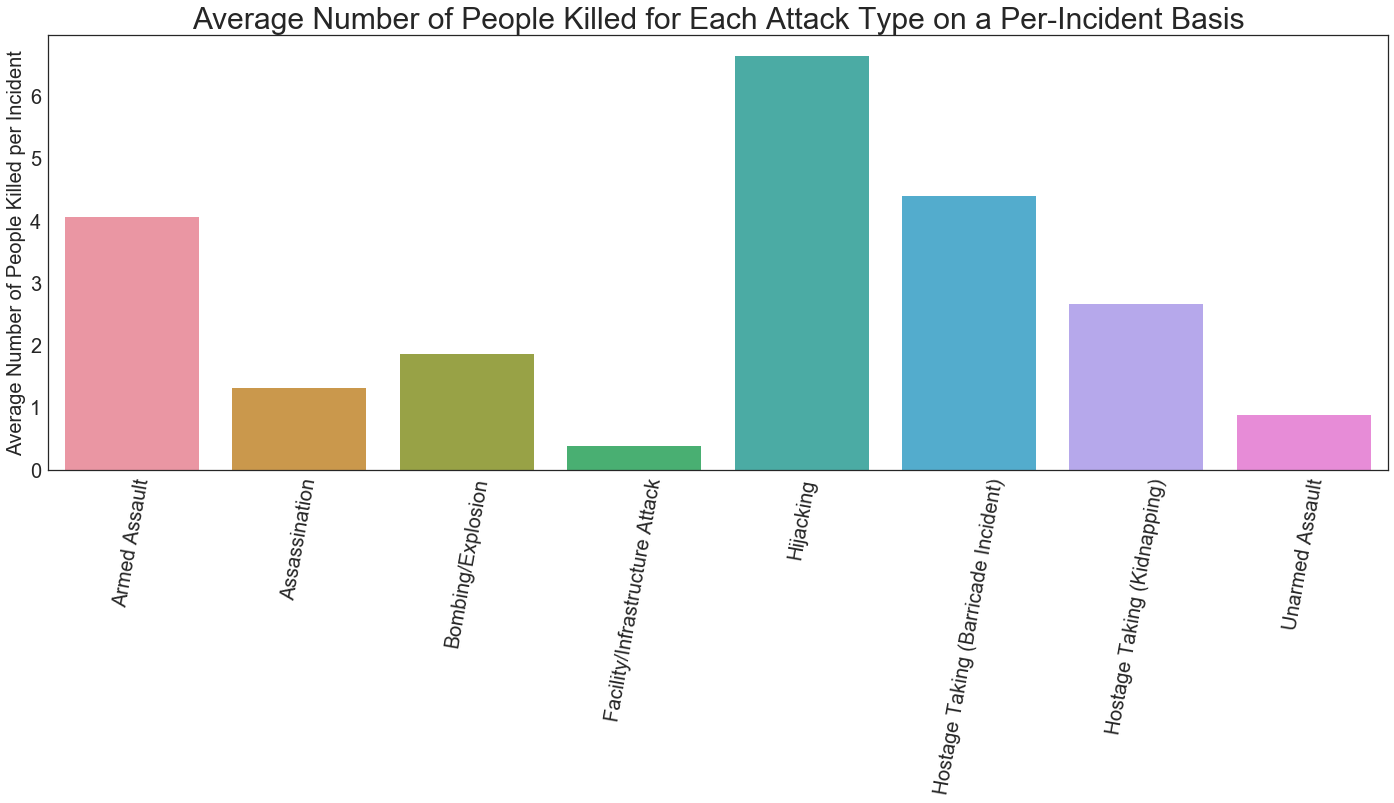

In [57]:
# Average Number of People Killed per Incident of Different Attack Types
sns.set_style('white')  
plt.figure(figsize=(24, 8))
sns.barplot(x='attack_type', y='killed', data=df_graph)
plt.title('Average Number of People Killed for Each Attack Type on a Per-Incident Basis', fontsize=30)
plt.xticks(rotation=80, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('')
plt.ylabel('Average Number of People Killed per Incident', fontsize=20)

----
### In the United States:

In [58]:
# Subset the data frame to U.S. data only.
df_usa = df[df.country == 'United States']

In [59]:
# Check the head of data frame
df_usa.head(2)

,year,country,region,state,city,attack_type,target_type,weapon_type,killed,summary,success
5,1970,United States,North America,Illinois,Cairo,Armed Assault,Police,Firearms,0.0,1/1/1970: Unknown African American assailants ...,1
7,1970,United States,North America,California,Oakland,Bombing/Explosion,Utilities,Explosives/Bombs/Dynamite,0.0,1/2/1970: Unknown perpetrators detonated explo...,1


In [60]:
# df_usa.info()

In [61]:
df_usa.describe()

,year,killed,success
count,2745.000000,2672.000000,2745.000000
mean,1983.190528,1.365269,0.824408
std,13.359426,38.152071,0.380542
min,1970.000000,0.000000,0.000000
25%,1971.000000,0.000000,1.000000
50%,1978.000000,0.000000,1.000000
75%,1992.000000,0.000000,1.000000
max,2016.000000,1383.000000,1.000000


In [62]:
# df_usa.provstate.value_counts()

In [63]:
# Group the U.S data by state
state_count = df_usa.groupby('state')[['year']].count()
state_count = state_count.reset_index()
state_count.columns = ['state', 'number_of_attacks']
state_count.head()

,state,number_of_attacks
0,Alabama,15
1,Alaska,1
2,Arizona,34
3,Arkansas,5
4,California,582


In [64]:
# Found this state code v.s state name dictionary from the internet.
state_dict = {"AL": "Alabama",
              "AK": "Alaska",
              "AS": "American Samoa",
              "AZ": "Arizona",
              "AR": "Arkansas",
              "CA": "California",
              "CO": "Colorado",
              "CT": "Connecticut",
              "DE": "Delaware",
              "DC": "District Of Columbia",
              "FM": "Federated States Of Micronesia",
              "FL": "Florida",
              "GA": "Georgia",
              "GU": "Guam",
              "HI": "Hawaii",
              "ID": "Idaho",
              "IL": "Illinois",
              "IN": "Indiana",
              "IA": "Iowa",
              "KS": "Kansas",
              "KY": "Kentucky",
              "LA": "Louisiana",
              "ME": "Maine",
              "MH": "Marshall Islands",
              "MD": "Maryland",
              "MA": "Massachusetts",
              "MI": "Michigan",
              "MN": "Minnesota",
              "MS": "Mississippi",
              "MO": "Missouri",
              "MT": "Montana",
              "NE": "Nebraska",
              "NV": "Nevada",
              "NH": "New Hampshire",
              "NJ": "New Jersey",
              "NM": "New Mexico",
              "NY": "New York",
              "NC": "North Carolina",
              "ND": "North Dakota",
              "MP": "Northern Mariana Islands",
              "OH": "Ohio",
              "OK": "Oklahoma",
              "OR": "Oregon",
              "PW": "Palau",
              "PA": "Pennsylvania",
              "PR": "Puerto Rico",
              "RI": "Rhode Island",
              "SC": "South Carolina",
              "SD": "South Dakota",
              "TN": "Tennessee",
              "TX": "Texas",
              "UT": "Utah",
              "VT": "Vermont",
              "VI": "Virgin Islands",
              "VA": "Virginia",
              "WA": "Washington",
              "WV": "West Virginia",
              "WI": "Wisconsin",
              "WY": "Wyoming"
              }


In [65]:
# Reverse the dictionary
state_dict_reverse = {}

for k, v in state_dict.items():
    state_dict_reverse[v] = k

state_dict_reverse

{'Alabama': 'AL',
 'Alaska': 'AK',
 'American Samoa': 'AS',
 'Arizona': 'AZ',
 'Arkansas': 'AR',
 'California': 'CA',
 'Colorado': 'CO',
 'Connecticut': 'CT',
 'Delaware': 'DE',
 'District Of Columbia': 'DC',
 'Federated States Of Micronesia': 'FM',
 'Florida': 'FL',
 'Georgia': 'GA',
 'Guam': 'GU',
 'Hawaii': 'HI',
 'Idaho': 'ID',
 'Illinois': 'IL',
 'Indiana': 'IN',
 'Iowa': 'IA',
 'Kansas': 'KS',
 'Kentucky': 'KY',
 'Louisiana': 'LA',
 'Maine': 'ME',
 'Marshall Islands': 'MH',
 'Maryland': 'MD',
 'Massachusetts': 'MA',
 'Michigan': 'MI',
 'Minnesota': 'MN',
 'Mississippi': 'MS',
 'Missouri': 'MO',
 'Montana': 'MT',
 'Nebraska': 'NE',
 'Nevada': 'NV',
 'New Hampshire': 'NH',
 'New Jersey': 'NJ',
 'New Mexico': 'NM',
 'New York': 'NY',
 'North Carolina': 'NC',
 'North Dakota': 'ND',
 'Northern Mariana Islands': 'MP',
 'Ohio': 'OH',
 'Oklahoma': 'OK',
 'Oregon': 'OR',
 'Palau': 'PW',
 'Pennsylvania': 'PA',
 'Puerto Rico': 'PR',
 'Rhode Island': 'RI',
 'South Carolina': 'SC',
 'South Da

In [66]:
# Add the state code as a new column to the data frame
state_count['state_code'] = state_count['state'].map(state_dict_reverse)

In [67]:
# There are only a couple of rows that have missing value, drop them.
state_count.dropna(inplace=True)
state_count.sort_values(by='number_of_attacks', ascending=False)

,state,number_of_attacks,state_code
4,California,582,CA
32,New York,502,NY
39,Puerto Rico,244,PR
9,Florida,153,FL
13,Illinois,110,IL
49,Washington,98,WA
37,Oregon,65,OR
44,Texas,59,TX
21,Massachusetts,57,MA
35,Ohio,51,OH


In [68]:
# Do a choropleth map with iplot (interactive plot of a map):

data = dict(type = 'choropleth',
            colorscale=[[0, 'rgb(166,206,227)'], 
                        [0.25, 'rgb(31,120,180)'], 
                        [0.45, 'rgb(178,223,138)'], 
                        [0.65, 'rgb(51,160,44)'], 
                        [0.85, 'rgb(251,154,153)'], 
                        [1, 'rgb(227,26,28)']],
            locations = state_count['state_code'],
            z = state_count['number_of_attacks'],
            locationmode = 'USA-states',
            text = state_count['state'],
            marker = dict(line = dict(color = 'rgb(255,255,255)', width = 2)),
            colorbar = {'title': "Number of Attacks"}
            ) 

In [69]:
layout = dict(title = 'Number of Terrorist Attacks in the U.S. from 1970 to 2016',
              geo = dict(scope = 'usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)'
                         )
              )

In [70]:
choromap = go.Figure(data=[data], layout=layout)

In [71]:
# iplot(choromap)

**(Note that GitHub cannot display my interactive plot.)**

From the graph, we see that California and New York had the most terrorist attacks from 1970 to 2016.

----
Time trend from year 1970 to year 2016:

In [72]:
# Make a frequency table of year and state
df_state = pd.crosstab(index=df_usa.year, columns=df_usa.state)  
df_state.head()

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Unknown,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
year,,,,,,,,,,,,,,,,,,,,,
1970,2,0,2,0,98,13,7,0,12,13,...,2,8,0,1,0,0,20,1,21,0
1971,0,0,1,0,115,2,0,0,2,6,...,0,5,0,0,1,0,0,0,0,0
1972,0,0,0,0,16,0,0,0,1,3,...,0,1,0,0,0,1,1,0,0,0
1973,1,0,0,0,14,1,0,0,4,1,...,0,0,0,0,0,0,0,0,1,0
1974,0,0,0,0,30,3,1,0,5,7,...,0,0,0,0,0,0,0,0,0,0


----
Top 5 states that have the most number of attacks from 1970 to 2016:

In [73]:
# Reshape the data to sum number of attacks from 1970 to 2016
US_top5 = df_state.sum()
US_top5 = pd.DataFrame(US_top5)
US_top5.index.name = 'state'
US_top5.columns = ['counts']
US_top5.head()

,counts
state,
Alabama,15
Alaska,1
Arizona,34
Arkansas,5
California,582


In [74]:
# Reshape the data to find top 5 States with the Highest Number of Attacks from 1970 to 2016:
US_top5 = US_top5.sort_values(by=['counts'], ascending=False)[:5]
US_top5

,counts
state,
California,582
New York,502
Puerto Rico,244
Florida,153
Illinois,110


In [75]:
US_top5.index

Index(['California', 'New York', 'Puerto Rico', 'Florida', 'Illinois'], dtype='object', name='state')

In [76]:
# Subset the data frame df_state with the top 5 states  
US_top5 = df_state[['California', 'New York', 'Puerto Rico', 'Florida', 'Illinois']]
US_top5.head()

state,California,New York,Puerto Rico,Florida,Illinois
year,,,,,
1970,98,86,17,13,32
1971,115,43,10,6,3
1972,16,30,3,3,3
1973,14,23,3,1,1
1974,30,20,19,7,2


Text(0,0.5,'Count')

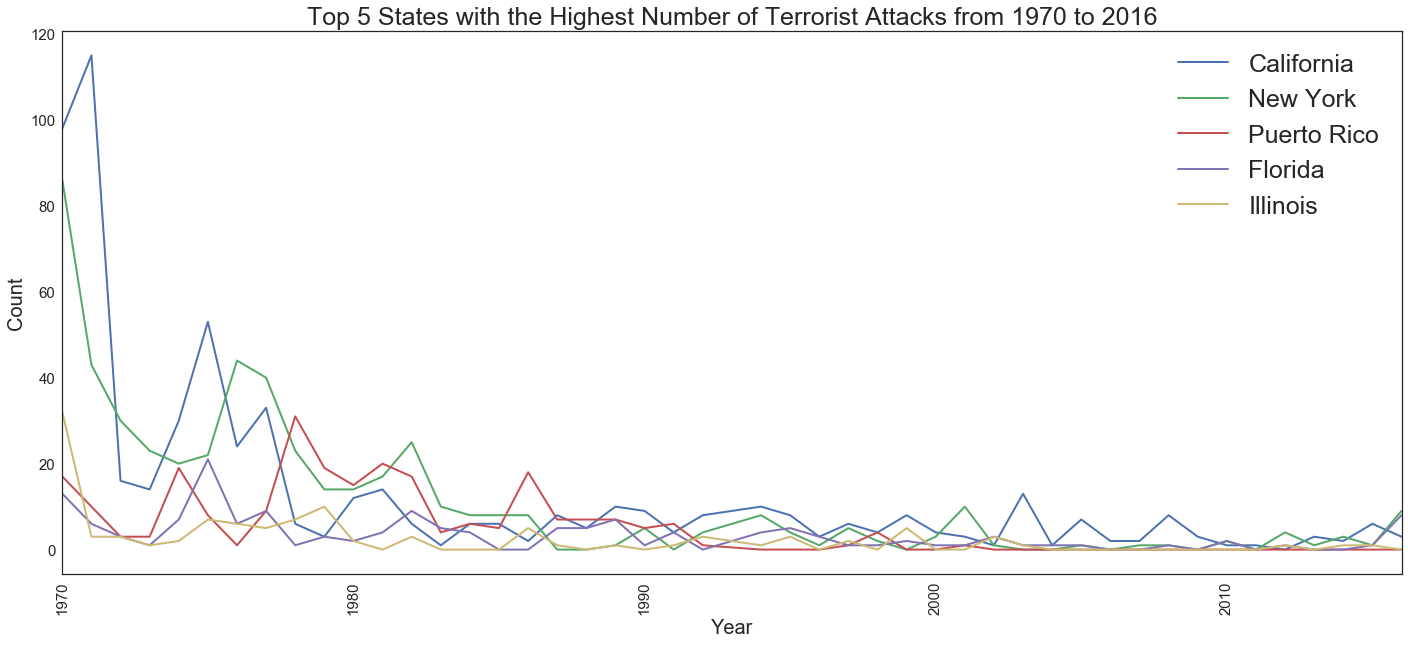

In [77]:
# Top 10 States and Territories with the Highest Number of Terrorist Attacks from 1970 to 2016
# Legend in descending order
sns.set_style('white')  
US_top5.plot(figsize=(24, 10), lw=2)
plt.legend(fontsize=25)
plt.title('Top 5 States with the Highest Number of Terrorist Attacks from 1970 to 2016', fontsize=25)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Count', fontsize=20)

This graph shows the top 5 states that have the most number of attacks. The order of the legend is also in the descending order of the highest number of attacks.

----
# Analysis Using Machine Learning

GOAL: I want to use ML and deep learning models to predict whether a terrorist attack will succeed or fail.

In [78]:
# Subset the df with all the columns I need for machine learning algorithms
df_ml = df[['country', 'region', 'attack_type', 'target_type', 'weapon_type', 'success']]

In [79]:
# Features
X = df_ml.drop('success', axis=1)

In [80]:
# Hot-encoding all features
X = pd.get_dummies(X, drop_first=True)

Since all features are categorical, we do not need to scale the features.

In [81]:
# Target
y = df_ml['success']

In [82]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

----

### Method 1: Logistic Regression

In [83]:
clf_lr = LogisticRegression(random_state=101, class_weight='balanced')
clf_lr

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=101,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [84]:
# Do a grid search on the best parameter C for the logistic regression model
param_grid = dict(C=[0.1, 1, 10])
grid_lr = GridSearchCV(clf_lr, param_grid=param_grid, refit=True, verbose=2)
grid_lr.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.6s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.9s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   1.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   1.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   1.5s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   1.5s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=101,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [85]:
grid_lr.best_params_

{'C': 10}

In [86]:
# Set pipe_lr to the best parameter
clf_lr.set_params(C=10, class_weight='balanced', random_state=101) 

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=101,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [87]:
# Fit the model
clf_lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=101,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
# Make predictions
y_predicted_lr = clf_lr.predict(X_test)

In [89]:
# Classification table
print("Logistic Regression:") 
print(classification_report(y_test, y_predicted_lr)) 

Logistic Regression:
             precision    recall  f1-score   support

          0       0.23      0.65      0.34      5184
          1       0.95      0.75      0.84     45249

avg / total       0.88      0.74      0.79     50433



----
### Method 2: Random Forest

In [90]:
# Make a pipeline
clf_rf = RandomForestClassifier(random_state=101, class_weight='balanced')
clf_rf

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=101,
            verbose=0, warm_start=False)

In [91]:
# Do a grid search on the best parameter n_estimators for the random forest model
param_grid = dict(n_estimators=[10, 20, 30])
grid_rf = GridSearchCV(clf_rf, param_grid=param_grid, refit=True, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   2.3s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   2.3s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   2.4s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=   4.6s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=   4.5s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=   4.5s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   6.7s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   6.6s
[CV] n_estimators=30 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   45.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=101,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=2)

In [92]:
grid_rf.best_params_

{'n_estimators': 30}

In [93]:
# Set pipe_rf to the best parameter
clf_rf.set_params(n_estimators=30, class_weight='balanced', random_state=101) 

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=101,
            verbose=0, warm_start=False)

In [94]:
# Fit the model
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=101,
            verbose=0, warm_start=False)

In [95]:
# Make predictions
y_predicted_rf = clf_rf.predict(X_test)

In [96]:
# Classification table
print("Random Forest:") 
print(classification_report(y_test, y_predicted_rf)) 

Random Forest:
             precision    recall  f1-score   support

          0       0.26      0.63      0.36      5184
          1       0.95      0.79      0.86     45249

avg / total       0.88      0.77      0.81     50433



----
### Method 3: Deep Learning - Artifical Neural Networks

Keras prefers numpy arrays as inputs, not pandas DataFrames or pandas Series.

In [97]:
# Change DataFrames / DataSeries to arrays
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [98]:
# Convert the target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [99]:
X.shape

(168108, 255)

In [100]:
# Specify the model
model_nn = Sequential()

model_nn.add(Dense(200, activation='relu', input_shape = (255, ) ))

# Add a dropout layer (regularization)
model_nn.add(Dropout(0.2))

model_nn.add(Dense(100, activation='relu'))

# Add a dropout layer (regularization)
model_nn.add(Dropout(0.2))

model_nn.add(Dense(50, activation='relu'))

# Add a dropout layer (regularization)
model_nn.add(Dropout(0.2))

model_nn.add(Dense(2, activation='sigmoid'))

# Summarize the model 
model_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               51200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [101]:
# Compile the model
model_nn.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [103]:
# Fit the model
model_nn.fit(X_train, y_train, class_weight='balanced', epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 82372 samples, validate on 35303 samples
Epoch 1/30
82372/82372 [==============================] - 7s 83us/step - loss: 0.3467 - acc: 0.8957 - val_loss: 0.3101 - val_acc: 0.8958
Epoch 2/30
82372/82372 [==============================] - 7s 81us/step - loss: 0.3003 - acc: 0.8976 - val_loss: 0.2854 - val_acc: 0.8958
Epoch 3/30
82372/82372 [==============================] - 7s 83us/step - loss: 0.2879 - acc: 0.8991 - val_loss: 0.2784 - val_acc: 0.9007
Epoch 4/30
82372/82372 [==============================] - 7s 81us/step - loss: 0.2826 - acc: 0.9030 - val_loss: 0.2740 - val_acc: 0.9071
Epoch 5/30
82372/82372 [==============================] - 7s 81us/step - loss: 0.2782 - acc: 0.9058 - val_loss: 0.2715 - val_acc: 0.9079
Epoch 6/30
82372/82372 [==============================] - 7s 80us/step - loss: 0.2764 - acc: 0.9067 - val_loss: 0.2699 - val_acc: 0.9088
Epoch 7/30
82372/82372 [==============================] - 7s 80us/step - loss: 0.2739 - acc: 0.9081 - val_loss: 0.2686 - val_acc

In [104]:
# Evaluate the model on test data: (valuation_loss, valuation_accuracy):
model_nn.evaluate(X_test, y_test)

50433/50433 [==============================] - 1s 27us/step


[0.26404498093935364, 0.90991017785973471]

In [105]:
y_predicted_nn = model_nn.predict(X_test)

In [106]:
# Convert predictions from probability to classification 
y_predicted_nn = (y_predicted_nn >= 0.5).astype(np.int)

In [107]:
# Classification table
print("Neural Networks:") 
print(classification_report(y_test, y_predicted_nn))

Neural Networks:
             precision    recall  f1-score   support

          0       0.68      0.24      0.35      5184
          1       0.92      0.99      0.95     45249

avg / total       0.89      0.91      0.89     50433



Text(0.5,0,'Epochs')

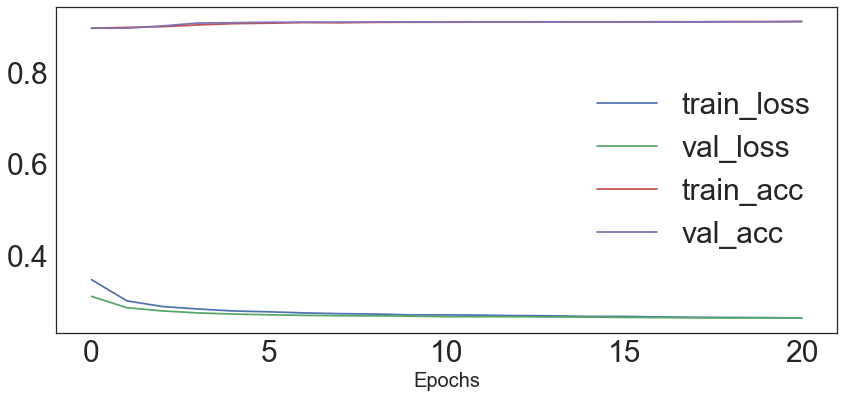

In [108]:
# Visualizing losses and accuracy
train_loss = model_nn.history.history['loss']
val_loss   = model_nn.history.history['val_loss']
train_acc  = model_nn.history.history['acc']
val_acc    = model_nn.history.history['val_acc']

sns.set_style('white')  
plt.figure(figsize=(14,6))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Epochs', fontsize=20)

----
#### So far, the nueral network model performs the best out of all 3 models. Let's fine-tune the ANN model.
#### Find the best learning rate:

In [109]:
def get_new_model(input_shape = (255, )):
    model = Sequential()
    model.add(Dense(200, activation='relu', input_shape = (255, ) ))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))
    return(model)

In [110]:
# Create list of learning rates: lr_to_test
lr_to_test = [0.001, 0.01, 0.1, 1]

# Loop over learning rates
for lr in lr_to_test:
    
    # Build new model to test, unaffected by previous models
    model = get_new_model()
    
    # Create SGD optimizer with specified learning rate: my_optimizer
    my_optimizer = SGD(lr=lr)
    
    # Compile the model
    model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define early_stopping_monitor
    early_stopping_monitor = EarlyStopping(patience=2)
    
    # Fit the model
    model.fit(X_train, y_train, class_weight='balanced', epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor], verbose=0)

    # Make predictions
    predictions = model.predict(X_test)
    
    # Convert predictions from probability to classification 
    predictions_binary = (predictions >= 0.5).astype(np.int)

    # Classification table
    print('\n\n\nTesting model with learning rate: %f\n'%lr )
    print(classification_report(y_test, predictions_binary))




Testing model with learning rate: 0.001000

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      5184
          1       0.90      1.00      0.95     45249

avg / total       0.80      0.90      0.85     50433




Testing model with learning rate: 0.010000

             precision    recall  f1-score   support

          0       0.67      0.24      0.36      5184
          1       0.92      0.99      0.95     45249

avg / total       0.89      0.91      0.89     50433




Testing model with learning rate: 0.100000

             precision    recall  f1-score   support

          0       0.67      0.25      0.36      5184
          1       0.92      0.99      0.95     45249

avg / total       0.89      0.91      0.89     50433




Testing model with learning rate: 1.000000

             precision    recall  f1-score   support

          0       0.64      0.26      0.37      5184
          1       0.92      0.98      0.95     45249

avg / 

Looks like the learning rate of 0.1 did the best.

---
### ROC Curves

In [111]:
# First, Let's reverse the one-hot encoding for the y_test:
y_test = pd.DataFrame(y_test)
y_test = y_test.idxmax(axis=1)

In [112]:
# Make a function to plot the ROC curve
def roc_plot(clf, label):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf,_ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr_rf, tpr_rf, label = label)
    print(label + " AUC: ", roc_auc_score(y_score = y_pred_proba, y_true = y_test))

Logistic Regression AUC:  0.771696422372
Random Fordest AUC:  0.776170574433
Neural Networks AUC:  0.800795097631


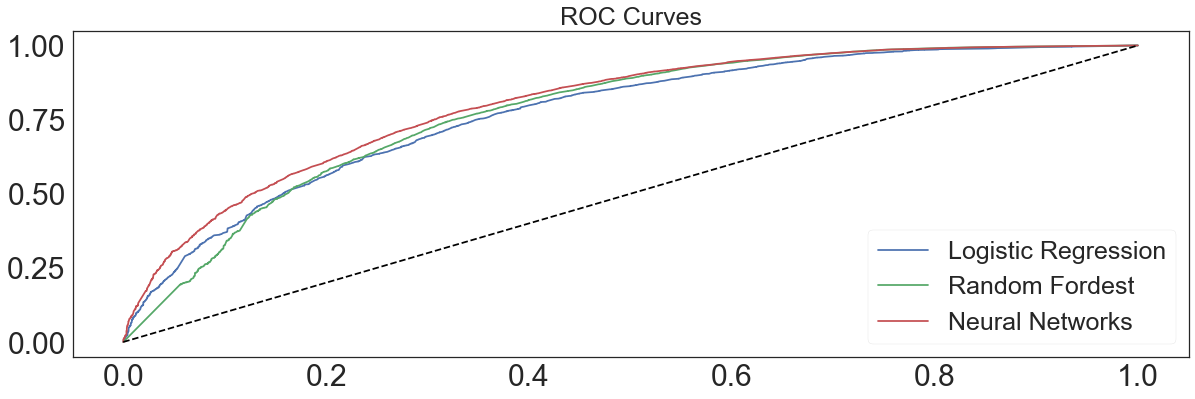

In [113]:
# Plot ROC Curves for all three models.
sns.set_style('white')  
plt.figure(figsize = (20,6))
roc_plot(clf_lr, 'Logistic Regression')
roc_plot(clf_rf, 'Random Fordest')
roc_plot(model_nn, 'Neural Networks')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves", fontsize=25)
plt.legend(loc='best', frameon=True, fontsize=25)

----
#### Feature Importance:

In [114]:
coeffecients = pd.DataFrame(clf_rf.feature_importances_, X.columns)
coeffecients.columns = ['coeffecient']

In [115]:
coeffecients.sort_values(by='coeffecient', ascending=False, inplace=True)

In [116]:
top15_coeffecients = coeffecients.head(15)

In [117]:
top15_coeffecients

,coeffecient
target_type_Unknown,0.118991
attack_type_Assassination,0.110776
weapon_type_Explosives/Bombs/Dynamite,0.035106
target_type_Private Citizens & Property,0.031651
weapon_type_Firearms,0.029093
attack_type_Bombing/Explosion,0.028823
attack_type_Hostage Taking (Kidnapping),0.024769
target_type_Government (General),0.023265
target_type_Military,0.023033
target_type_Police,0.020835


---
### The "Summary" column (NLP)

In [118]:
df_text = df[['summary', 'success']]

In [119]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168108 entries, 0 to 170350
Data columns (total 2 columns):
summary    103509 non-null object
success    168108 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.8+ MB


In [120]:
# Remove rows in df_text where the 'country' column contains missing value
df_text = df_text.dropna(subset=['summary'], axis=0)

In [121]:
# Replace the date in front of each sentence with '' for the 'summary' column:
df_text['summary'] = df_text['summary'].replace(r'\d{1,2}/\d{1,2}/\d{4}:\s{1}', '', regex=True)

In [122]:
df_text.head(2)

,summary,success
5,Unknown African American assailants fired seve...,1
7,Unknown perpetrators detonated explosives at t...,1


In [123]:
# Write a function to pre-process the text column:
def preprocessing(text):
    """
    Takes in a string, then performs the following:
    1. Make all lower case
    2. Keep only words and numbers (remove all punctuations, special characters, etc.)
    3. Remove all stopwords
    4. Lemmatize the remaining words
    5. Join the characters again to form the string
    5. Returns the cleaned text
    """
    tokens = word_tokenize(text)
    lower_tokens = [t.lower() for t in tokens]
    alnum_only = [t for t in lower_tokens if t.isalnum()]  # Retain alphanumeric words
    no_stops = [t for t in alnum_only if t not in stopwords.words('english')] # Remove stop words
    wordnet_lemmatizer = WordNetLemmatizer()  # Instantiate the WordNetLemmatizer
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]  # Lemmatize all tokens into a new list 
    return ' '.join(lemmatized)

In [124]:
# Apply the function to df_text['summary'] column:

# df_text['clean_summary'] = df_text['summary'].apply(preprocessing)

In [125]:
df_text['summary'].shape

(103509,)

Note that the above line of code takes too long to run with my CPU since I have 103,509 sentences to process.

So , I will use a subset of the original dataset to showcase how I process text data.

In [126]:
# Subset the df with all the columns I need for NLP
df_nlp = df[['country', 'region', 'attack_type', 'target_type', 'weapon_type', 'summary', 'success']]

In [127]:
# Drop missing value:
df_nlp = df_nlp.dropna(axis=0)

In [128]:
# Subset the df_nlp df into df_nlp_success and df_nlp_failure:
df_nlp_success = df_nlp.loc[df_nlp['success']==1, :]  
df_nlp_failure = df_nlp.loc[df_nlp['success']==0, :]  

In [129]:
# Randomly choose 5,000 records for the two dfs.
from numpy.random import RandomState, randint
set_seed = RandomState(101)
index_succeed = list(set_seed.randint(low=0, high=df_nlp_success.shape[0]+1, size=5000))
index_failure = list(set_seed.randint(low=0, high=df_nlp_failure.shape[0]+1, size=5000))

In [130]:
df_subset_success = df_nlp_success.iloc[index_succeed, :]
df_subset_failure = df_nlp_failure.iloc[index_failure, :]

In [131]:
# append the two subsets together:
df_subset = df_subset_success.append(df_subset_failure)

In [132]:
df_subset.head()

,country,region,attack_type,target_type,weapon_type,summary,success
116555,Pakistan,South Asia,Bombing/Explosion,Military,Explosives/Bombs/Dynamite,05/02/2013: Assailants launched rockets into P...,1
160075,Pakistan,South Asia,Bombing/Explosion,Police,Explosives/Bombs/Dynamite,03/24/2016: Assailants threw an explosive devi...,1
159821,Libya,Middle East & North Africa,Bombing/Explosion,Police,Explosives/Bombs/Dynamite,03/17/2016: Assailants attacked a prison in Zl...,1
147979,India,South Asia,Unarmed Assault,Private Citizens & Property,Melee,05/19/2015: Assailants attacked civilians in G...,1
72563,Spain,Western Europe,Facility/Infrastructure Attack,Government (General),Incendiary,08/11/2001: An arson attack by unidentified pe...,1


In [133]:
df_subset.success.value_counts()

1    5000
0    5000
Name: success, dtype: int64

In [134]:
# Replace the date in front of each sentence with ''
df_subset['summary'] = df_subset['summary'].replace(r'\d{1,2}/\d{1,2}/\d{4}:\s{1}', '', regex=True)

In [135]:
# Write a function to pre-process the text column:
def preprocessing(text):
    """
    Takes in a string, then performs the following:
    1. Make all lower case
    2. Keep only words and numbers (remove all punctuations, special characters, etc.)
    3. Remove all stopwords
    4. Lemmatize the remaining words
    5. Join the characters again to form the string
    5. Returns the cleaned text
    """
    tokens = word_tokenize(text)
    lower_tokens = [t.lower() for t in tokens]
    alnum_only = [t for t in lower_tokens if t.isalnum()]  # Retain alphanumeric words
    no_stops = [t for t in alnum_only if t not in stopwords.words('english')] # Remove stop words
    wordnet_lemmatizer = WordNetLemmatizer()  # Instantiate the WordNetLemmatizer
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]  # Lemmatize all tokens into a new list 
    return ' '.join(lemmatized)

In [136]:
# Apply the function to df_text['summary'] column:
df_subset['clean_summary'] = df_subset['summary'].apply(preprocessing)

Visualize the most common words with the 'success' label being either 1 or 0:

In [137]:
# Make a Pandas series with cleaned text when 'success' = 1
series_success = df_subset.loc[df_subset['success']==1, 'clean_summary']  

In [138]:
# Make a Pandas series with cleaned text when 'success' = 0
series_failure = df_subset.loc[df_subset['success']==0, 'clean_summary']  

In [139]:
# Make a frequent distribution of the words for the "success" rows
txt = series_success.str.cat(sep=' ')
words = word_tokenize(txt)
word_dist_success = FreqDist(words)

In [140]:
# Make a frequent distribution of the words for the "failure" rows
txt = series_failure.str.cat(sep=' ')
words = word_tokenize(txt)
word_dist_failure = FreqDist(words)

In [141]:
# Get the top 20 most common words with "success" label:
count_success = Counter(word_dist_success).most_common(20)  

In [142]:
# Get the top 20 most common words with "failure" label:
count_failure = Counter(word_dist_failure).most_common(20)  

In [143]:
names, values = zip(*count_success)

In [144]:
d = {'names': names, 'values': values}
df_count_success = pd.DataFrame(data=d)

Text(0,0.5,'Count')

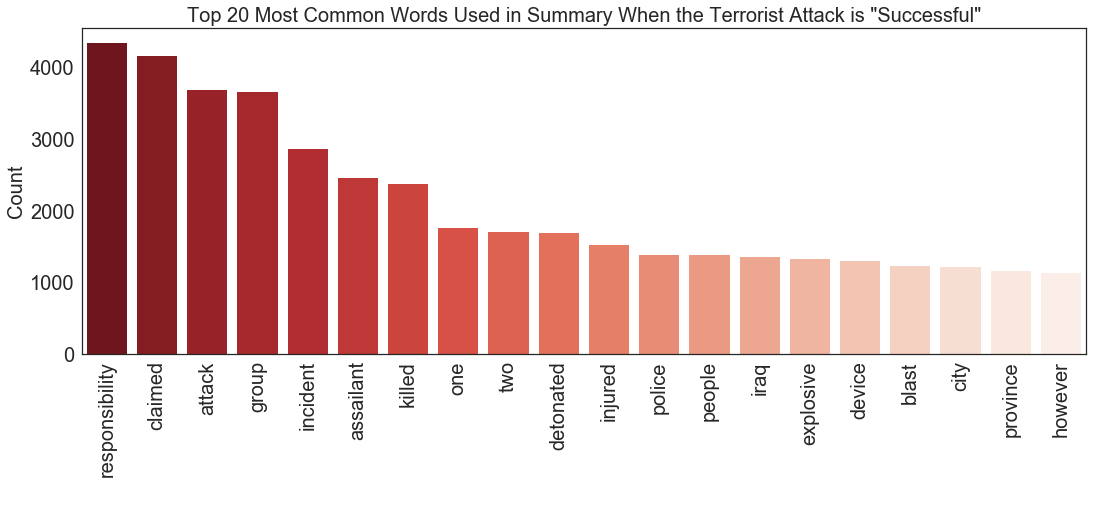

In [145]:
sns.set_style('white')  
plt.figure(figsize=(18, 6))
sns.barplot(x='names', y='values', data=df_count_success, palette='Reds_r')
plt.title('Top 20 Most Common Words Used in Summary When the Terrorist Attack is "Successful"', fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(' ') 
plt.ylabel('Count', fontsize=20)

In [146]:
names, values = zip(*count_failure)

In [147]:
d = {'names': names, 'values': values}
df_count_failure = pd.DataFrame(data=d)

Text(0,0.5,'Count')

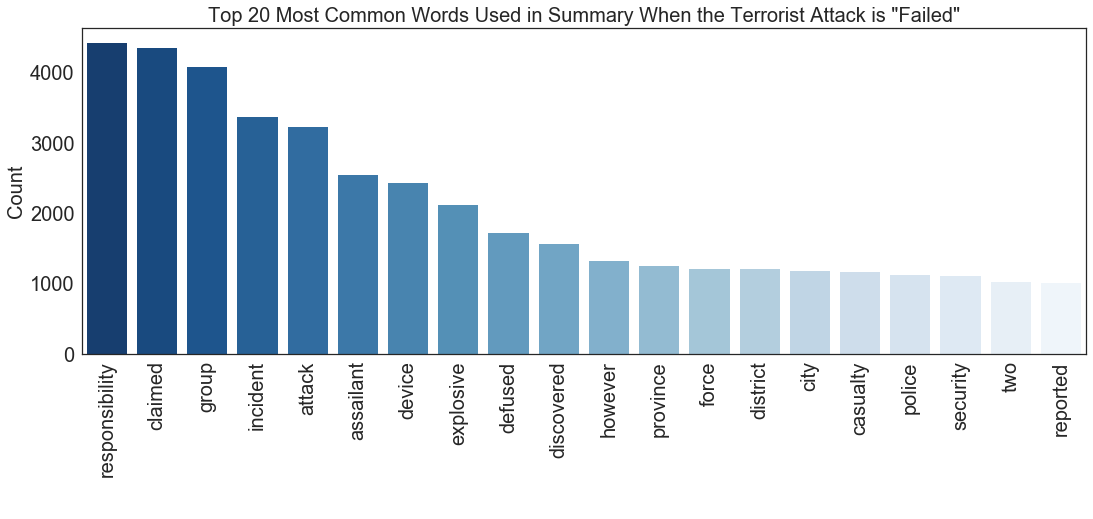

In [148]:
sns.set_style('white')  
plt.figure(figsize=(18, 6))
sns.barplot(x='names', y='values', data=df_count_failure, palette='Blues_r')
plt.title('Top 20 Most Common Words Used in Summary When the Terrorist Attack is "Failed"', fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(' ') 
plt.ylabel('Count', fontsize=20)

Now, let's see how much predictive power the 'summary' column alone has on whether an attack is a success or failure.

In [149]:
df_subset.head(1)

,country,region,attack_type,target_type,weapon_type,summary,success,clean_summary
116555,Pakistan,South Asia,Bombing/Explosion,Military,Explosives/Bombs/Dynamite,Assailants launched rockets into Panjgoor dist...,1,assailant launched rocket panjgoor district ba...


In [150]:
# NOTE: Both X and y must be series to use count_vectorizer and tfidf_vectorizer.
# Features
X = df_subset['clean_summary']

In [151]:
# Target
y = df_subset['success']

In [152]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [153]:
# Transform X
tfidf_X = tfidf_vectorizer.fit_transform(X)

In [154]:
tfidf_X

<10000x16234 sparse matrix of type '<class 'numpy.float64'>'
	with 232831 stored elements in Compressed Sparse Row format>

In [155]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, y, test_size=0.3, random_state=101)

In [156]:
# ChangeDataSeries to arrays
# X_train, X_test are sparse matrices with numpy.float64 type of numerics
y_train = y_train.values
y_test = y_test.values

In [157]:
# Convert the target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [158]:
X_train.shape

(7000, 16234)

In [159]:
# Specify the model
model_nn_1 = Sequential()

model_nn_1.add(Dense(200, activation='relu', input_shape = (16234, ) ))

# Add a dropout layer (regularization)
model_nn_1.add(Dropout(0.2))

model_nn_1.add(Dense(100, activation='relu'))

# Add a dropout layer (regularization)
model_nn_1.add(Dropout(0.2))

model_nn_1.add(Dense(50, activation='relu'))

# Add a dropout layer (regularization)
model_nn_1.add(Dropout(0.2))

model_nn_1.add(Dense(2, activation='sigmoid'))

# Summarize the model 
model_nn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 200)               3247000   
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 102       
Total para

In [160]:
# Compile the model
model_nn_1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [161]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [162]:
# Fit the model
model_nn_1.fit(X_train, y_train, epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 4900 samples, validate on 2100 samples
Epoch 1/30
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6930 - acc: 0.5108 - val_loss: 0.6930 - val_acc: 0.4950
Epoch 2/30
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6926 - acc: 0.5128 - val_loss: 0.6925 - val_acc: 0.5281
Epoch 3/30
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6922 - acc: 0.5292 - val_loss: 0.6921 - val_acc: 0.5360
Epoch 4/30
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6916 - acc: 0.5401 - val_loss: 0.6916 - val_acc: 0.5021
Epoch 5/30
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6909 - acc: 0.5420 - val_loss: 0.6906 - val_acc: 0.5917
Epoch 6/30
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6901 - acc: 0.5836 - val_loss: 0.6899 - val_acc: 0.5098
Epoch 7/30
4900/4900 [==============================] - 6s 1ms/step - loss: 0.6891 - acc: 0.5737 - val_loss: 0.6888 - val_acc: 0.5412
Epoch 8/30
490

In [163]:
# Evaluate the model on test data: (valuation_loss, valuation_accuracy):
model_nn_1.evaluate(X_test, y_test)

3000/3000 [==============================] - 1s 281us/step


[0.45954396080970766, 0.83066666650772092]

In [164]:
y_predicted_nn_1 = model_nn_1.predict(X_test)

In [165]:
# Convert predictions from probability to classification 
y_predicted_nn_1 = (y_predicted_nn_1 >= 0.5).astype(np.int)

In [166]:
# Classification table
print("Neural Networks Model with Text Column Only:") 
print(classification_report(y_test, y_predicted_nn_1))

Neural Networks Model with Text Column Only:
             precision    recall  f1-score   support

          0       0.91      0.74      0.81      1496
          1       0.78      0.92      0.84      1504

avg / total       0.84      0.83      0.83      3000



Text(0.5,0,'Epochs')

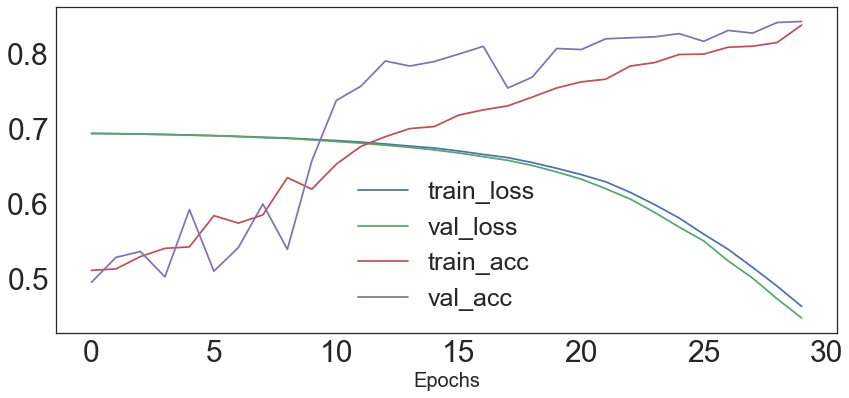

In [167]:
# Visualizing losses and accuracy
train_loss = model_nn_1.history.history['loss']
val_loss   = model_nn_1.history.history['val_loss']
train_acc  = model_nn_1.history.history['acc']
val_acc    = model_nn_1.history.history['val_acc']

sns.set_style('white')  
plt.figure(figsize=(14,6))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best', fontsize=25)
plt.xlabel('Epochs', fontsize=20)

The result is not bad at all, given we only used 10,000 entries from the original 103,509 entries to train and test the model.

----
Can we improve the model further if we add back all other features we used before? Let's see.

In [168]:
tfidf_X.shape

(10000, 16234)

In [169]:
type(tfidf_X)

scipy.sparse.csr.csr_matrix

In [170]:
# Convert a sparse matrix to a Pandas df:
tfidf_X_df = pd.DataFrame( tfidf_X.todense())

In [171]:
df_subset.head(1)

,country,region,attack_type,target_type,weapon_type,summary,success,clean_summary
116555,Pakistan,South Asia,Bombing/Explosion,Military,Explosives/Bombs/Dynamite,Assailants launched rockets into Panjgoor dist...,1,assailant launched rocket panjgoor district ba...


In [172]:
# Subset the df with all the columns I need for NLP
df_features = df_subset[['country', 'region', 'attack_type', 'target_type', 'weapon_type']]

In [173]:
# Hot-encoding all features in df_features
df_features = pd.get_dummies(df_features, drop_first=True)

In [174]:
type(df_features)

pandas.core.frame.DataFrame

In [175]:
df_features.shape

(10000, 172)

In [176]:
# reindex the df_features df to index from zero to len(df_features) (exclusive)
df_features.index = np.arange(len(df_features))

In [177]:
X = pd.concat([df_features, tfidf_X_df], axis=1, ignore_index=True )

In [178]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 16406 entries, 0 to 16405
dtypes: float64(16234), uint8(172)
memory usage: 1.2 GB


In [179]:
type(y)

pandas.core.series.Series

In [180]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [181]:
# Change DataSeries to arrays to prepare to feed into Neural Network model
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [182]:
# Convert the target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [183]:
X_train.shape

(7000, 16406)

In [184]:
# Specify the model
model_nn_2 = Sequential()

model_nn_2.add(Dense(200, activation='relu', input_shape = (16406, ) ))

# Add a dropout layer (regularization)
model_nn_2.add(Dropout(0.2))

model_nn_2.add(Dense(100, activation='relu'))

# Add a dropout layer (regularization)
model_nn_2.add(Dropout(0.2))

model_nn_2.add(Dense(50, activation='relu'))

# Add a dropout layer (regularization)
model_nn_2.add(Dropout(0.2))

model_nn_2.add(Dense(2, activation='sigmoid'))

# Summarize the model 
model_nn_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 200)               3281400   
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 102       
Total para

In [185]:
# Compile the model
model_nn_2.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [186]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [187]:
# Fit the model
model_nn_2.fit(X_train, y_train, epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 4900 samples, validate on 2100 samples
Epoch 1/30
4900/4900 [==============================] - 8s 2ms/step - loss: 0.6928 - acc: 0.5097 - val_loss: 0.6925 - val_acc: 0.5271
Epoch 2/30
4900/4900 [==============================] - 7s 1ms/step - loss: 0.6919 - acc: 0.5480 - val_loss: 0.6913 - val_acc: 0.5500
Epoch 3/30
4900/4900 [==============================] - 7s 1ms/step - loss: 0.6906 - acc: 0.5771 - val_loss: 0.6894 - val_acc: 0.6181
Epoch 4/30
4900/4900 [==============================] - 7s 1ms/step - loss: 0.6886 - acc: 0.5966 - val_loss: 0.6869 - val_acc: 0.6440
Epoch 5/30
4900/4900 [==============================] - 7s 1ms/step - loss: 0.6859 - acc: 0.6148 - val_loss: 0.6834 - val_acc: 0.6843
Epoch 6/30
4900/4900 [==============================] - 7s 1ms/step - loss: 0.6826 - acc: 0.6411 - val_loss: 0.6791 - val_acc: 0.6857
Epoch 7/30
4900/4900 [==============================] - 7s 1ms/step - loss: 0.6779 - acc: 0.6666 - val_loss: 0.6736 - val_acc: 0.6919
Epoch 8/30
490

In [188]:
# Evaluate the model on test data: (valuation_loss, valuation_accuracy):
model_nn_2.evaluate(X_test, y_test)

3000/3000 [==============================] - 1s 318us/step


[0.3471782714128494, 0.86666666650772095]

In [189]:
y_predicted_nn_2 = model_nn_2.predict(X_test)

In [190]:
# Convert predictions from probability to classification 
y_predicted_nn_2 = (y_predicted_nn_2 >= 0.5).astype(np.int)

In [191]:
# Classification table
print("Neural Networks Model with Text Column and Other Features:") 
print(classification_report(y_test, y_predicted_nn_2))

Neural Networks Model with Text Column and Other Features:
             precision    recall  f1-score   support

          0       0.86      0.87      0.87      1496
          1       0.87      0.86      0.87      1504

avg / total       0.87      0.87      0.87      3000



Text(0.5,0,'Epochs')

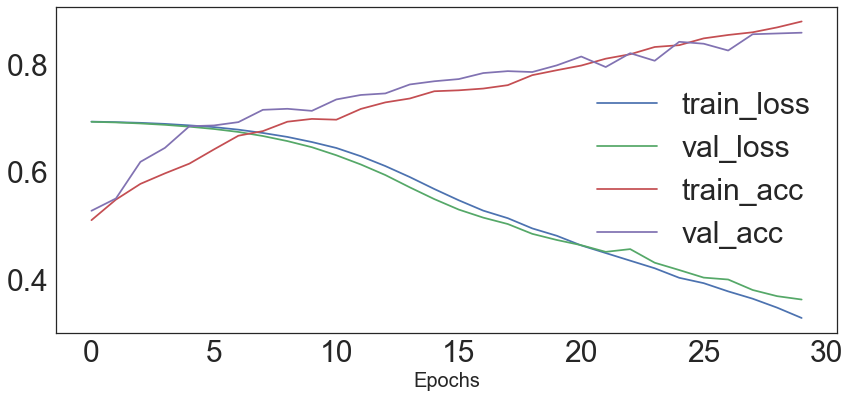

In [192]:
# Visualizing losses and accuracy
train_loss = model_nn_2.history.history['loss']
val_loss   = model_nn_2.history.history['val_loss']
train_acc  = model_nn_2.history.history['acc']
val_acc    = model_nn_2.history.history['val_acc']

sns.set_style('white')  
plt.figure(figsize=(14,6))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Epochs', fontsize=20)

As we can see, there is a huge improvement on the model performance, especially with the model's predictibility with the failed terrorist attacks.    
Please keep in mind that we're only using 10,000 records at this point, which is % of the whole dataset.

----
Future work: Use GPU or AWS to run the whole dataset to get better results.